### Let's see whether we can predict the duration and Actual net revenue of projects

In [1]:
#!pip install pydlm

In [78]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from statsmodels.tsa.arima_model import ARIMA
import itertools
%matplotlib inline

In [79]:
df = pd.read_csv('mv_port_processed_clusters.csv')

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (16,46) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [80]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df['Project Number'] = df['Project Number'].astype('str') 
df = df.loc[:, ~df.columns.str.contains('^index')]

df = df[df['Project Number'] != 'fw0labor00in'] 
df = df[df['Project Number'] != 'fw0labor0out']

In [81]:
df.columns

Index(['Project Name', 'Health and Safety Status', 'Project Status',
       'SalesCloudClientNo', 'Contract Type Name',
       'Ultimate Customer AUS Market Sector', 'Division Short Name',
       'location_2', 'location_4', 'Region', 'Country', 'Proj_CVP',
       'Proj_Serv_Offering', 'CVP Description', 'primary_client_industry',
       'Sales Cloud Opportunity Number', 'Funding Amount - ITC (Snapshot)',
       'Backlog NR', 'Actual Direct Labor Cost - MTD',
       'Actual Non-Labor Cost - MTD', 'Actual Gross Revenue - MTD',
       'Actual Net Revenue - MTD', 'EBITA - MTD',
       'Forecast Direct Labor Cost - ITC', 'Forecast Net Revenue - ITC',
       'Order Intake (NR) - MTD', 'bookings_jtd', 'interest_current',
       'interest_jtd', 'interest_ytd', 'multiplier_budget',
       'multiplier_current', 'multiplier_target', 'overhead_current',
       'overhead_rate', 'revenue_type', 'AUS Mkt Sector Aggregate',
       'Baseline NR', 'Break Even Multiplier - Project', 'Organization Size',


In [82]:
df_sub = df[['Date','Project Number','Actual Net Revenue - MTD','Project Status', 'Contract Type Name', 'Ultimate Customer AUS Market Sector', 'Division Short Name', 'Proj_CVP', 'Proj_Serv_Offering',
             'primary_client_industry', 'Funding Amount - ITC (Snapshot)', 'Backlog NR',  'Actual Direct Labor Cost - MTD', 'Actual Non-Labor Cost - MTD',
       'Actual Gross Revenue - MTD', 'EBITA - MTD', 'ADL_shifted', 'ANR_shifted', 'ANR_previous_year',
       'Forecast Direct Labor Cost - ITC', 'Forecast Net Revenue - ITC',
       'Order Intake (NR) - MTD', 'AUS Mkt Sector Aggregate', 'Baseline NR', 'Organization Size',
       'Risk Profile', 'riskrating_project', 'ActualNR_sum', 'Projectduration', 'Completion', 'scheduled_duration', 'Scheduled_projectduration', 'intime', 'seasonality_month', 'Month']]

In [83]:
df_sub.isna().sum()

Date                                   0
Project Number                         0
Actual Net Revenue - MTD               0
Project Status                         0
Contract Type Name                     0
Ultimate Customer AUS Market Sector    0
Division Short Name                    0
Proj_CVP                               0
Proj_Serv_Offering                     0
primary_client_industry                0
Funding Amount - ITC (Snapshot)        0
Backlog NR                             0
Actual Direct Labor Cost - MTD         0
Actual Non-Labor Cost - MTD            0
Actual Gross Revenue - MTD             0
EBITA - MTD                            0
ADL_shifted                            0
ANR_shifted                            0
ANR_previous_year                      0
Forecast Direct Labor Cost - ITC       0
Forecast Net Revenue - ITC             0
Order Intake (NR) - MTD                0
AUS Mkt Sector Aggregate               0
Baseline NR                            0
Organization Siz

In [84]:
df_subset = df_sub.drop_duplicates(subset=['Project Number'], keep='last')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)


millions_formatter = FuncFormatter(millions)

sub=df_subset.groupby(['Project Number'])['ActualNR_sum'].sum().reset_index()

sub = sub[sub['ActualNR_sum'] > - 1000000000]
sub = sub[sub['ActualNR_sum'] < 1000000000]

sub.plot(x='Project Number', y='ActualNR_sum', kind='scatter', figsize=(7,5))
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.gca().set_ylabel('Sum of net Revenue (in millions)')
plt.show()

In [30]:
len(df_sub)

1266893

In [85]:
df_sub['scheduled_duration'] = df_sub['scheduled_duration'].replace(np.nan, 0)
df_sub['scheduled_duration'] = df_sub['scheduled_duration'].astype('int') 

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/julia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### We need to dummy encode now

In [19]:
''' 
Project_Status = pd.get_dummies(df_sub['Project Status'])
Contract_Name = pd.get_dummies(df_sub['Contract Type Name'])
Ultimate_AUS = pd.get_dummies(df_sub['Ultimate Customer AUS Market Sector'])
Divison = pd.get_dummies(df_sub['Division Short Name'])
#Region = pd.get_dummies(df_sub['Region'], drop_first=True)
Proj_CVP = pd.get_dummies(df_sub['Proj_CVP'])
Proj_Serv_Offering = pd.get_dummies(df_sub['Proj_Serv_Offering'])
Client = pd.get_dummies(df_sub['primary_client_industry'])
Aggregate_AUS = pd.get_dummies(df_sub['AUS Mkt Sector Aggregate'])
Orgsize = pd.get_dummies(df_sub['Organization Size'])
Profile = pd.get_dummies(df_sub['Risk Profile'])



df_sub = pd.concat([df_sub, Project_Status], axis=1)
df_sub = pd.concat([df_sub, Contract_Name], axis=1)
df_sub = pd.concat([df_sub, Ultimate_AUS], axis=1)
df_sub = pd.concat([df_sub, Divison], axis=1)
#df_sub = pd.concat([df_sub, Region], axis=1)
df_sub = pd.concat([df_sub, Proj_CVP], axis=1)
df_sub = pd.concat([df_sub, Proj_Serv_Offering], axis=1)
df_sub = pd.concat([df_sub, Client], axis=1)
df_sub = pd.concat([df_sub, Aggregate_AUS], axis=1)
df_sub = pd.concat([df_sub, Orgsize], axis=1)
df_sub = pd.concat([df_sub, Profile], axis=1)

df_sub = df_sub.drop(columns=['Project Status', 'Contract Type Name', 'Ultimate Customer AUS Market Sector', 'Division Short Name',
                              'Proj_CVP', 'Proj_Serv_Offering', 'primary_client_industry', 'AUS Mkt Sector Aggregate', 'Organization Size', 'Risk Profile'])
df_sub

correlation_df = df[['Actual Net Revenue - MTD', 'Funding Amount - ITC (Snapshot)', 'Backlog NR', 'Actual Direct Labor Cost - MTD', 'Actual Non-Labor Cost - MTD', 'Actual Non-Labor Cost - MTD', 'EBITA - MTD', 'Forecast Direct Labor Cost - ITC', 
                    'Forecast Net Revenue - ITC', 'Order Intake (NR) - MTD', 'Baseline NR', 'riskrating_project', 'ActualNR_sum', 'Projectduration', 'Completion', 'Scheduled_projectduration', 'seasonality_month']]



df_sub.corr(method ='pearson')

'''

,Funding Amount - ITC (Snapshot),Backlog NR,Actual Direct Labor Cost - MTD,Actual Non-Labor Cost - MTD,Actual Gross Revenue - MTD,Actual Net Revenue - MTD,EBITA - MTD,Forecast Direct Labor Cost - ITC,Forecast Net Revenue - ITC,Order Intake (NR) - MTD,...,Transp/Log,Key Global,Key Local,Key Regional,Local,RKC,Unspecified,Low,Medium,Unspecified
Funding Amount - ITC (Snapshot),1.000000,0.438156,0.019451,0.373201,0.060993,0.020088,0.021686,0.722600,0.746455,0.078865,...,-0.029490,-0.008763,-0.000166,0.001705,-0.013314,0.051806,-0.010906,-0.045112,0.053158,-0.056150
Backlog NR,0.438156,1.000000,0.021418,0.186730,0.037168,0.020349,0.011202,0.514491,0.532115,0.201932,...,-0.018655,-0.010816,-0.003163,-0.004490,0.000298,0.040833,-0.015491,-0.023658,0.052349,-0.036174
Actual Direct Labor Cost - MTD,0.019451,0.021418,1.000000,0.359079,0.988012,0.993394,0.645172,0.023820,0.023433,0.006276,...,-0.000979,-0.000693,-0.000114,0.000391,0.000009,0.002342,-0.001480,-0.000620,0.003996,-0.001715
Actual Non-Labor Cost - MTD,0.373201,0.186730,0.359079,1.000000,0.770852,0.158402,-0.006945,0.149755,0.153377,0.039923,...,-0.004912,-0.005098,-0.001673,0.010147,-0.002441,0.004993,0.004484,-0.020732,0.012788,-0.002610
Actual Gross Revenue - MTD,0.060993,0.037168,0.988012,0.770852,1.000000,0.994429,0.722923,0.039366,0.041204,0.040976,...,-0.001402,-0.001072,-0.000223,0.001263,-0.000046,0.004166,-0.002799,-0.000607,0.006174,-0.003328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RKC,0.051806,0.040833,0.002342,0.004993,0.004166,0.002374,0.001805,0.063419,0.066124,0.004837,...,0.230834,-0.072962,-0.028525,-0.085375,-0.353903,1.000000,-0.292005,0.066210,-0.016663,0.114710
Unspecified,-0.010906,-0.015491,-0.001480,0.004484,-0.002799,-0.001467,-0.000933,-0.021259,-0.017914,0.002381,...,-0.016468,-0.087353,-0.034151,-0.102215,-0.423708,-0.292005,1.000000,-0.144381,-0.059060,-0.300722
Low,-0.045112,-0.023658,-0.000620,-0.020732,-0.000607,-0.000608,-0.000143,-0.057229,-0.062760,-0.001619,...,0.084702,-0.001940,0.009343,0.087572,-0.035269,0.066210,-0.144381,1.000000,-0.429314,-0.414702
Medium,0.053158,0.052349,0.003996,0.012788,0.006174,0.004069,0.002707,0.073793,0.080322,0.014984,...,0.047165,0.070268,0.036376,0.047724,0.043817,-0.016663,-0.059060,-0.429314,1.000000,-0.269732


### Now let's do a regression on Project status

In [86]:
df_sub['Project Status'].unique()

array(['Open/Active', 'On Hold - Inactive', 'Closed',
       'Closed-Open to Collect', 'Final Closure Requested', 'Unspecified',
       'New - Pending Approval', 'Rejected', 'New', 'Manual_Adj'],
      dtype=object)

In [87]:
''' We need to get the project numbers where we have closed entries, get the variables from the first entry but the actualNR Sum of the last entry'''

df_closed = df_sub[df_sub['Project Status'] == 'Closed']
df_opentocollect = df_sub[df_sub['Project Status'] == 'Closed-Open to Collect']


df_merged = pd.concat([df_opentocollect, df_closed])
df_merged.drop_duplicates(subset=['Project Number'], keep='last', inplace=True)
df_projnumber = df_merged[['Project Number', 'ActualNR_sum']].copy()

#use the df_sub again and just keep all first entries, then merge on project number only
df_first = df_sub.drop_duplicates(subset=['Project Number'], keep='first')

df_actualNR = pd.merge(df_projnumber, df_first, how='inner', on='Project Number')

#df_actualNR = df_sub[df_sub['ActualNR_sum'] != ]

len(df_actualNR)

32067

In [88]:
df_actualNR.pop('Project Status')
df_actualNR.pop('Project Number')
df_actualNR.pop('ActualNR_sum_y')
'This one we cant know'
df_actualNR.pop('Projectduration')
df_actualNR.pop('Completion')
df_actualNR.pop('intime')

0        0
1        0
2        0
3        0
4        0
        ..
32062    0
32063    0
32064    0
32065    0
32066    0
Name: intime, Length: 32067, dtype: int64

In [89]:
### Now let's dummy encode
Contract_Name = pd.get_dummies(df_actualNR['Contract Type Name'])
Ultimate_AUS = pd.get_dummies(df_actualNR['Ultimate Customer AUS Market Sector'])
Divison = pd.get_dummies(df_actualNR['Division Short Name'])
#Region = pd.get_dummies(df_sub['Region'], drop_first=True)
Proj_CVP = pd.get_dummies(df_actualNR['Proj_CVP'])
Proj_Serv_Offering = pd.get_dummies(df_actualNR['Proj_Serv_Offering'])
Client = pd.get_dummies(df_actualNR['primary_client_industry'])
Aggregate_AUS = pd.get_dummies(df_actualNR['AUS Mkt Sector Aggregate'])
Orgsize = pd.get_dummies(df_actualNR['Organization Size'])
Profile = pd.get_dummies(df_actualNR['Risk Profile'])
Date = pd.get_dummies(df_actualNR['Date'])



df_actualNR = pd.concat([df_actualNR, Date], axis=1)
df_actualNR = pd.concat([df_actualNR, Contract_Name], axis=1)
df_actualNR = pd.concat([df_actualNR, Ultimate_AUS], axis=1)
df_actualNR = pd.concat([df_actualNR, Divison], axis=1)
#df_sub = pd.concat([df_sub, Region], axis=1)
df_actualNR = pd.concat([df_actualNR, Proj_CVP], axis=1)
df_actualNR = pd.concat([df_actualNR, Proj_Serv_Offering], axis=1)
df_actualNR = pd.concat([df_actualNR, Client], axis=1)
df_actualNR = pd.concat([df_actualNR, Aggregate_AUS], axis=1)
df_actualNR = pd.concat([df_actualNR, Orgsize], axis=1)
df_actualNR = pd.concat([df_actualNR, Profile], axis=1)

df_actualNR = df_actualNR.drop(columns=['Date','Contract Type Name', 'Ultimate Customer AUS Market Sector', 'Division Short Name',
                              'Proj_CVP', 'Proj_Serv_Offering', 'primary_client_industry', 'AUS Mkt Sector Aggregate', 'Organization Size', 'Risk Profile'])
df_actualNR

,ActualNR_sum_x,Actual Net Revenue - MTD,Funding Amount - ITC (Snapshot),Backlog NR,Actual Direct Labor Cost - MTD,Actual Non-Labor Cost - MTD,Actual Gross Revenue - MTD,EBITA - MTD,ADL_shifted,ANR_shifted,...,Public,Transp/Log,Key Global,Key Regional,Local,Unspecified,High,Low,Medium,Unspecified
0,21839,2900.00,733572,92293.61,1276.25,0.00,2900.00,-111.9500,2.453807e+07,6.702559e+07,...,0,0,0,0,0,1,1,0,0,0
1,9093,0.00,97237,0.00,757.88,2700.00,2700.00,-1788.5968,2.453807e+07,6.702559e+07,...,0,0,0,0,0,1,1,0,0,0
2,-5175,397.50,386461,0.00,277.66,0.00,397.50,-257.7776,2.453807e+07,6.702559e+07,...,0,0,0,0,0,1,0,1,0,0
3,1177,706.50,22500,942.00,220.50,0.00,706.50,186.1200,2.453807e+07,6.702559e+07,...,0,0,0,0,0,1,0,1,0,0
4,13458,817.24,50676,0.00,537.55,14.92,832.16,-451.3780,2.453807e+07,6.702559e+07,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32062,32140,14996.00,44575,0.00,4700.65,0.00,14996.00,3152.7100,5.147722e+06,1.471307e+07,...,0,0,0,1,0,0,0,0,0,1
32063,2793,0.00,0,0.00,0.00,0.00,0.00,0.0000,1.082843e+07,2.861349e+07,...,0,0,0,0,1,0,0,0,0,1
32064,39282,1176.01,43500,24729.07,454.76,0.00,1176.01,148.0700,1.322915e+07,3.297292e+07,...,0,0,1,0,0,0,0,0,0,1
32065,51657,0.00,107400,48943.24,0.00,0.00,0.00,0.0000,1.671872e+07,4.562350e+07,...,0,0,1,0,0,0,0,0,0,1


In [90]:
import numpy as np

len(df_actualNR)
df_actualNR.replace([np.inf, -np.inf], np.nan, inplace=True)
df_actualNR=df_actualNR.fillna(0)
df_actualNR=df_actualNR.replace(np.nan,0)

In [91]:
df_actualNR.head()

,ActualNR_sum_x,Actual Net Revenue - MTD,Funding Amount - ITC (Snapshot),Backlog NR,Actual Direct Labor Cost - MTD,Actual Non-Labor Cost - MTD,Actual Gross Revenue - MTD,EBITA - MTD,ADL_shifted,ANR_shifted,...,Public,Transp/Log,Key Global,Key Regional,Local,Unspecified,High,Low,Medium,Unspecified
0,21839,2900.00,733572,92293.61,1276.25,0.00,2900.00,-111.9500,2.453807e+07,6.702559e+07,...,0,0,0,0,0,1,1,0,0,0
1,9093,0.00,97237,0.00,757.88,2700.00,2700.00,-1788.5968,2.453807e+07,6.702559e+07,...,0,0,0,0,0,1,1,0,0,0
2,-5175,397.50,386461,0.00,277.66,0.00,397.50,-257.7776,2.453807e+07,6.702559e+07,...,0,0,0,0,0,1,0,1,0,0
3,1177,706.50,22500,942.00,220.50,0.00,706.50,186.1200,2.453807e+07,6.702559e+07,...,0,0,0,0,0,1,0,1,0,0
4,13458,817.24,50676,0.00,537.55,14.92,832.16,-451.3780,2.453807e+07,6.702559e+07,...,0,0,0,0,0,1,1,0,0,0


In [19]:
''' Lets do the split '''

from sklearn.model_selection import train_test_split

X = df_actualNR.iloc[:,1:]
y = df_actualNR.iloc[:,:1]

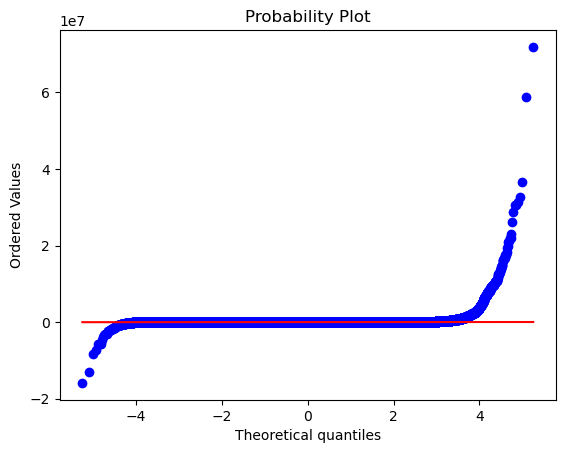

In [78]:
#Variables follow a Normal Distribution
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(X.values.ravel(), dist="norm", plot=plt)
plt.show()

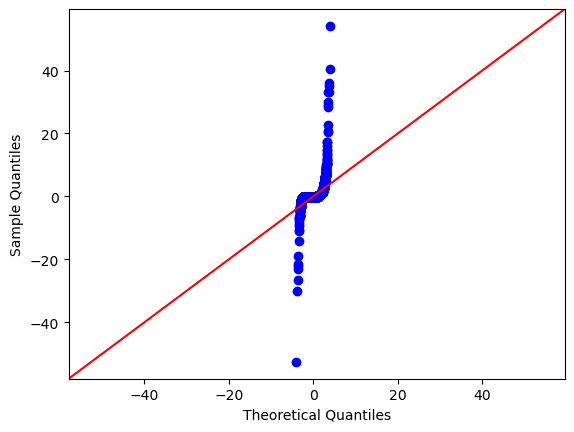

In [80]:
import numpy as np
import statsmodels.api as sm
import pylab

sm.qqplot(y.ravel(), line='45')
pylab.show()

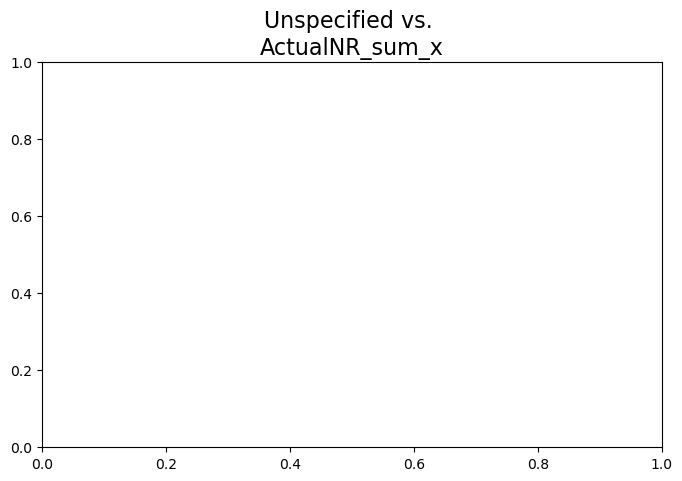

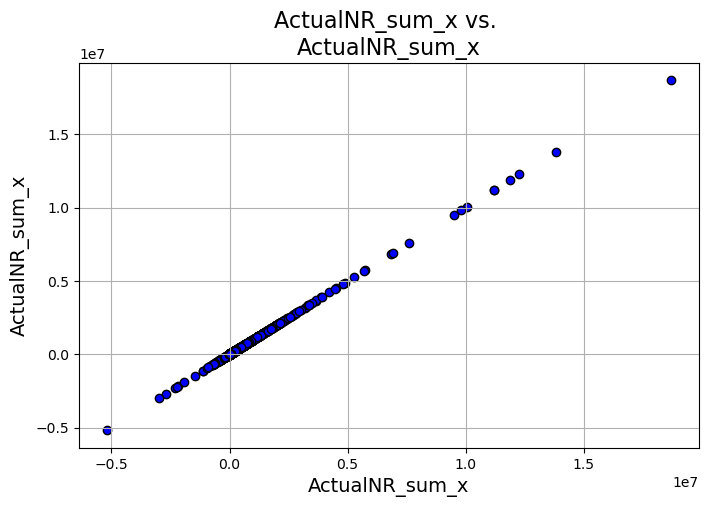

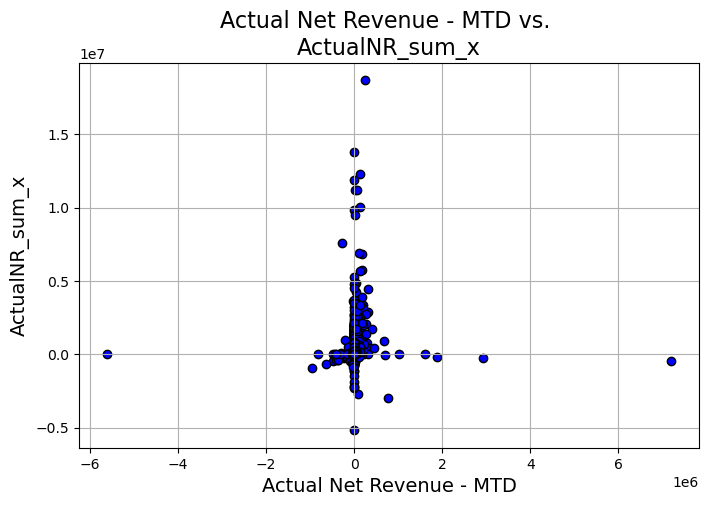

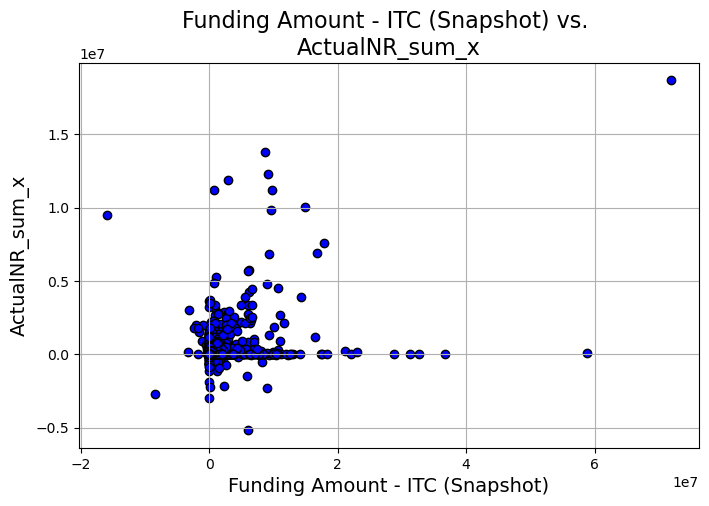

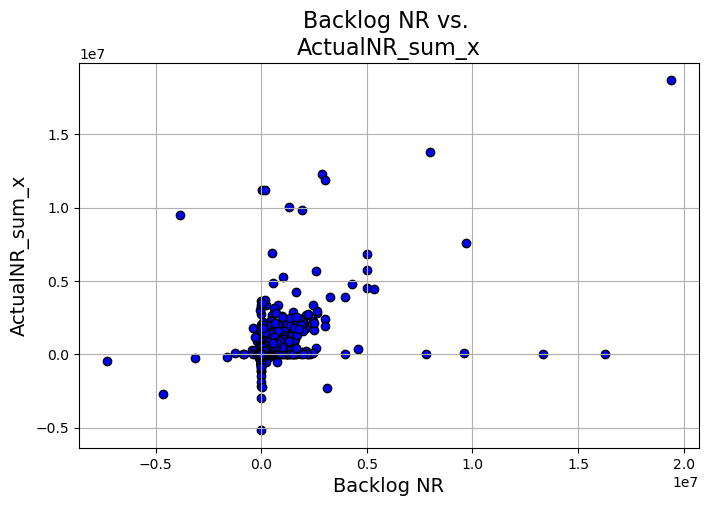

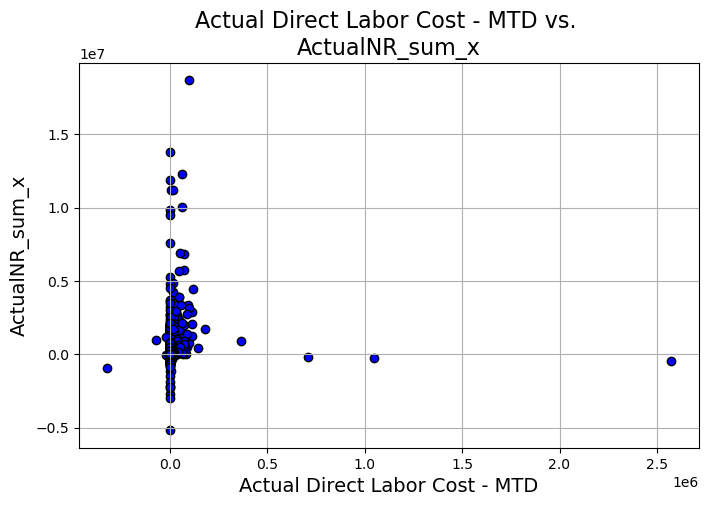

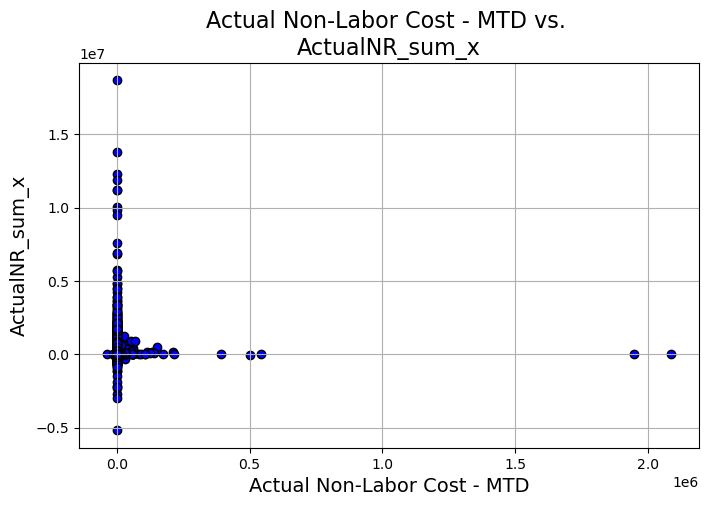

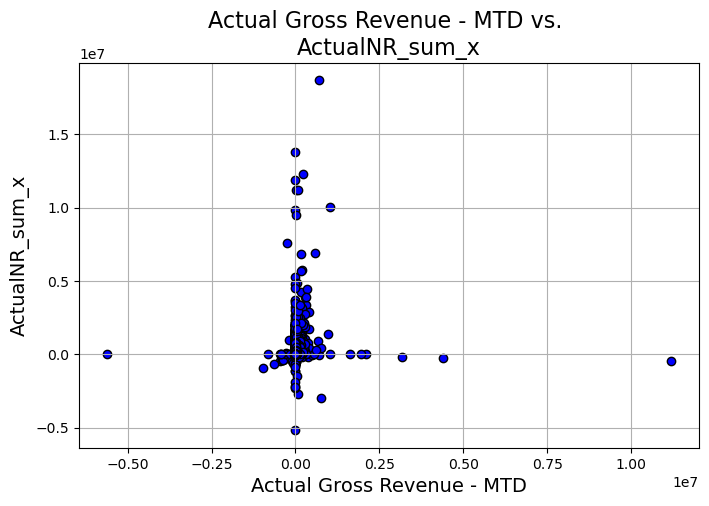

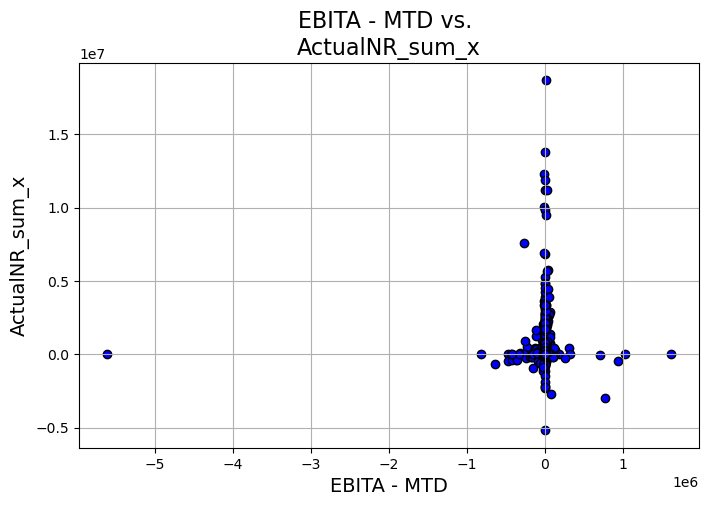

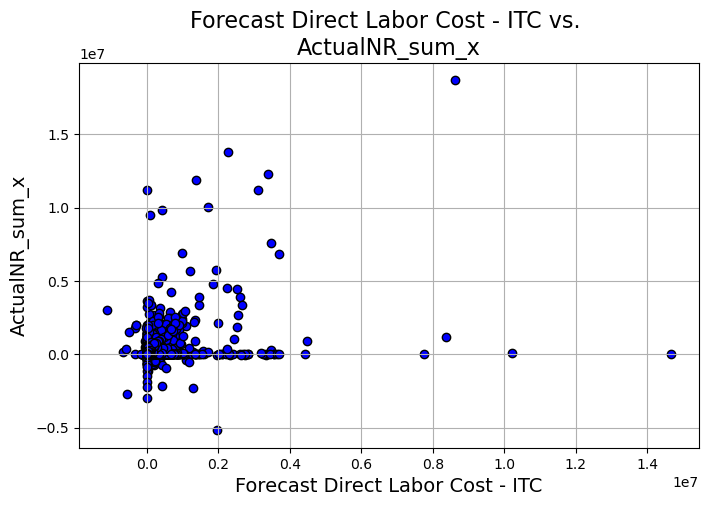

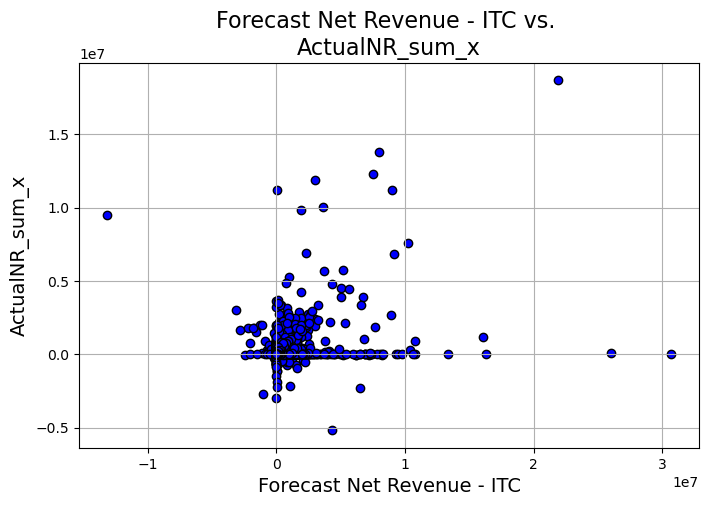

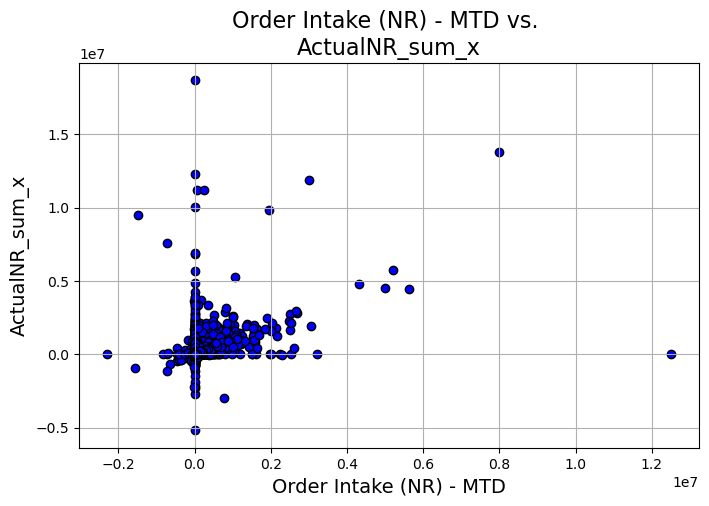

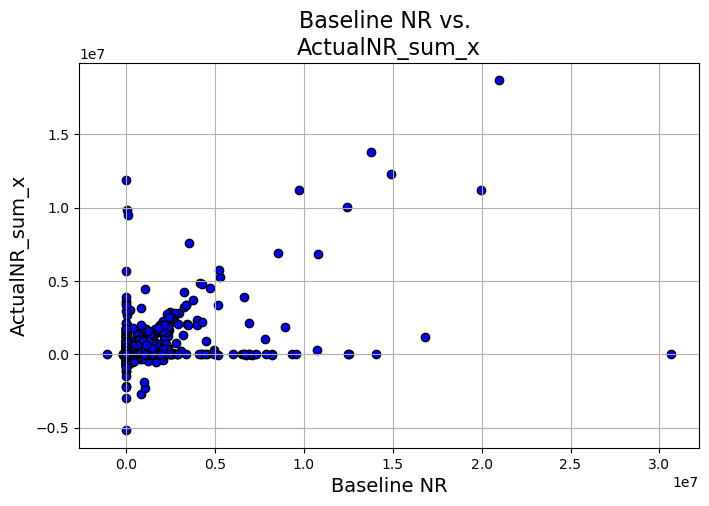

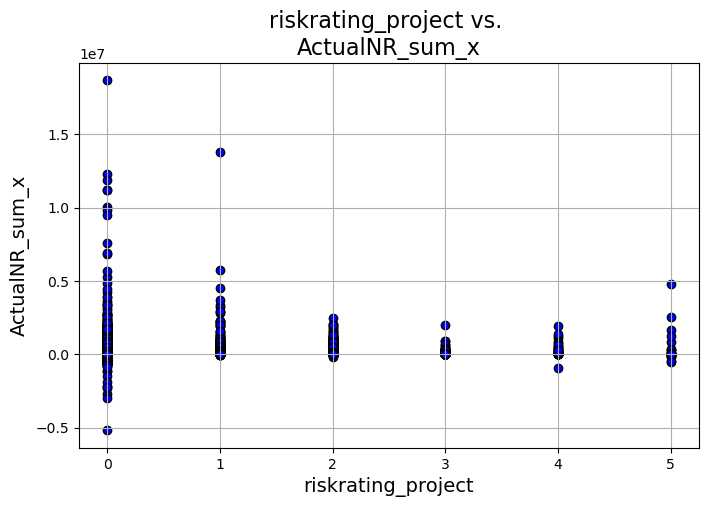

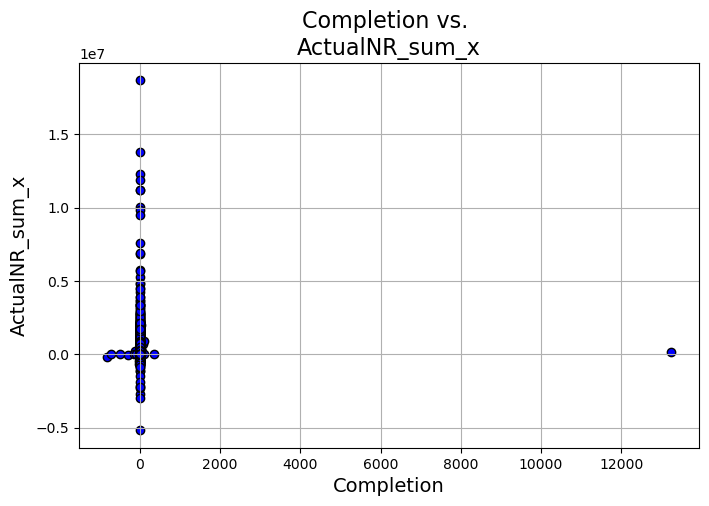

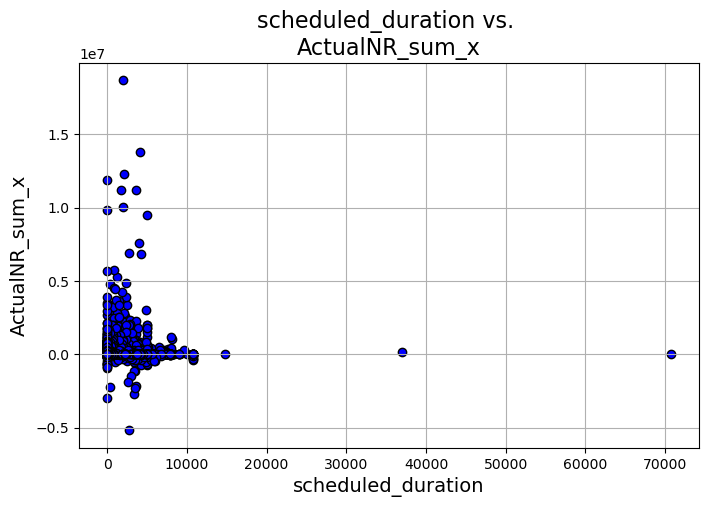

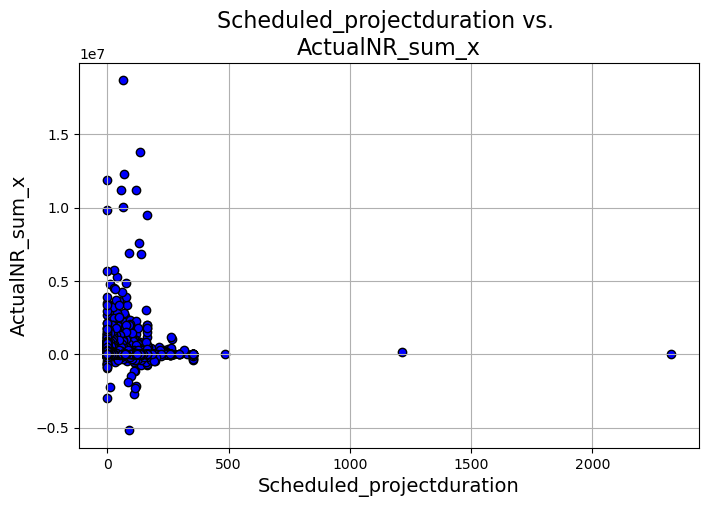

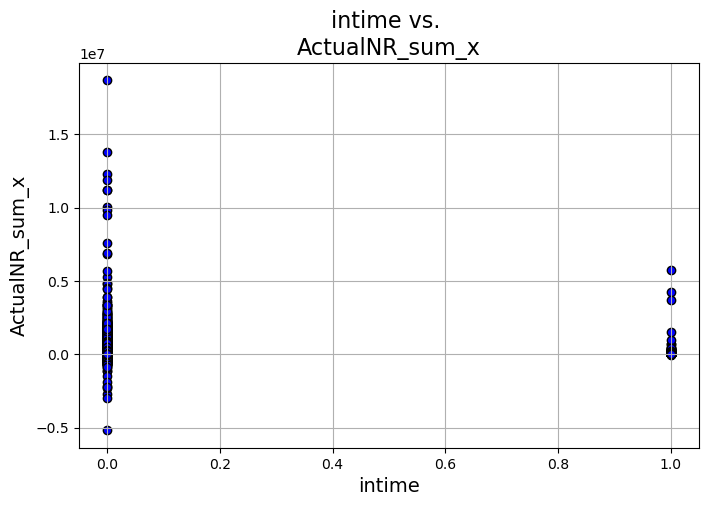

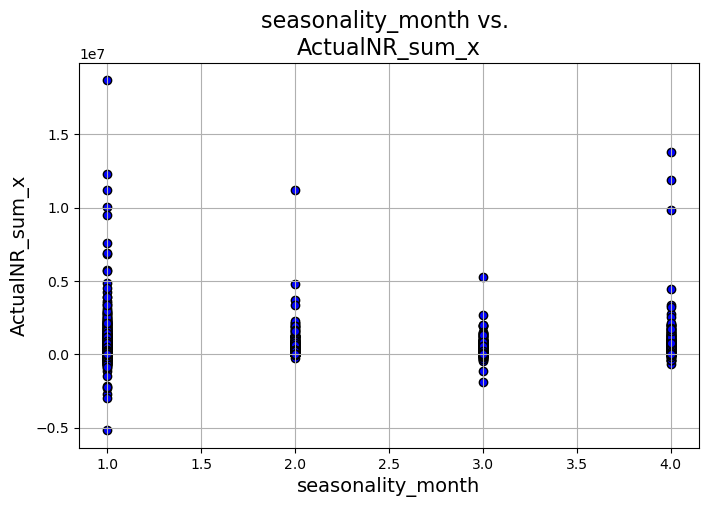

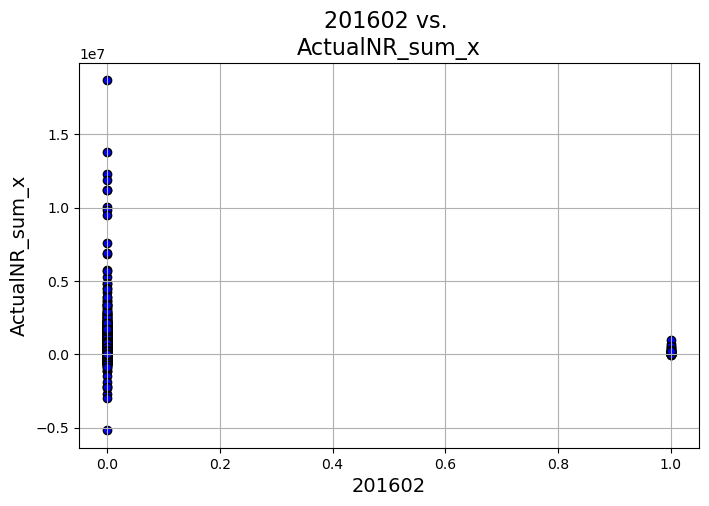

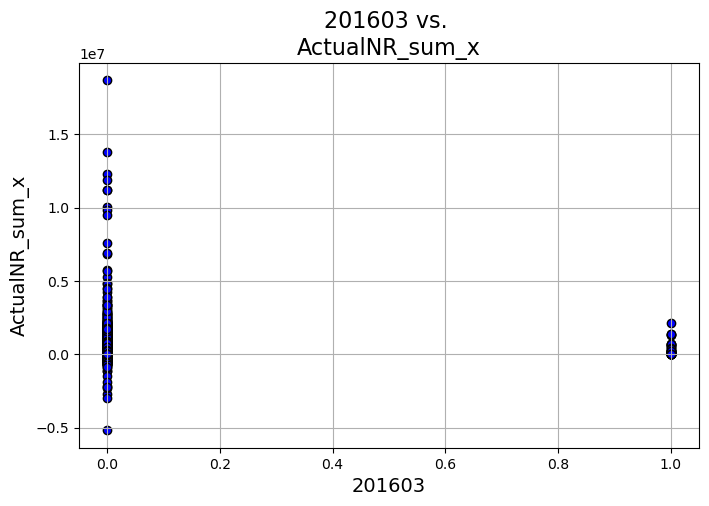

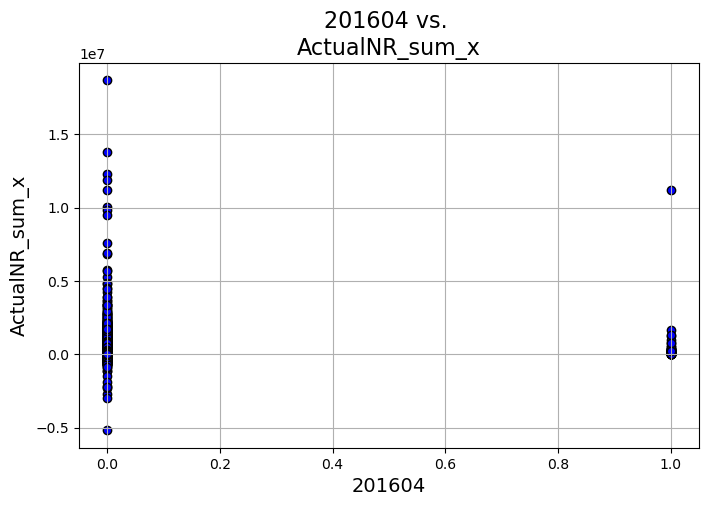

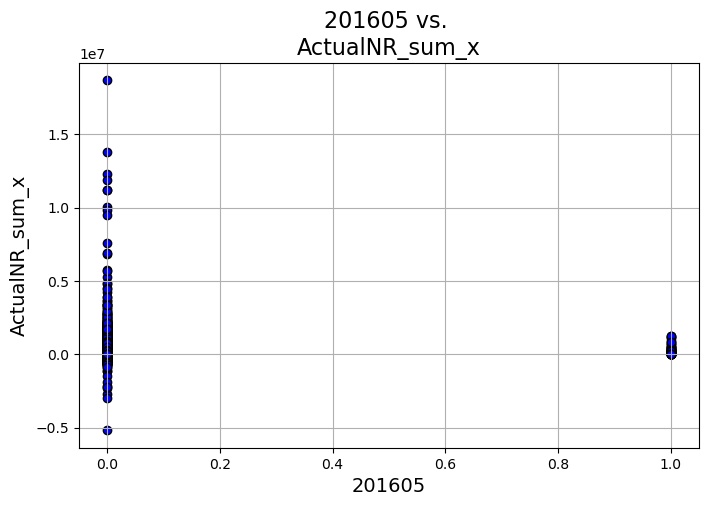

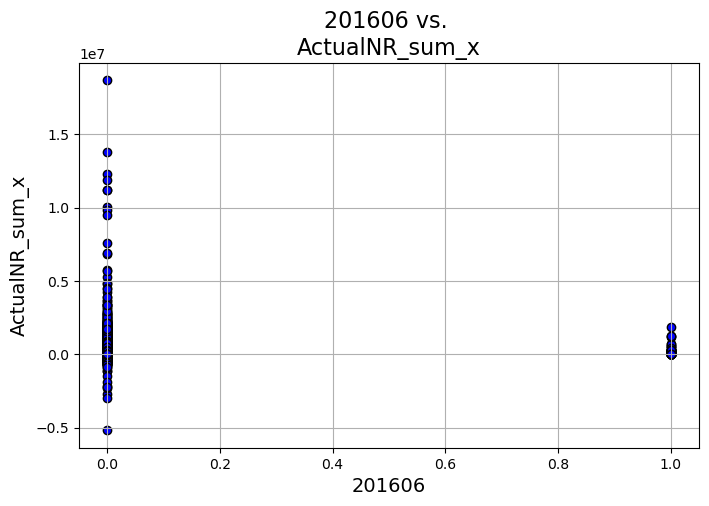

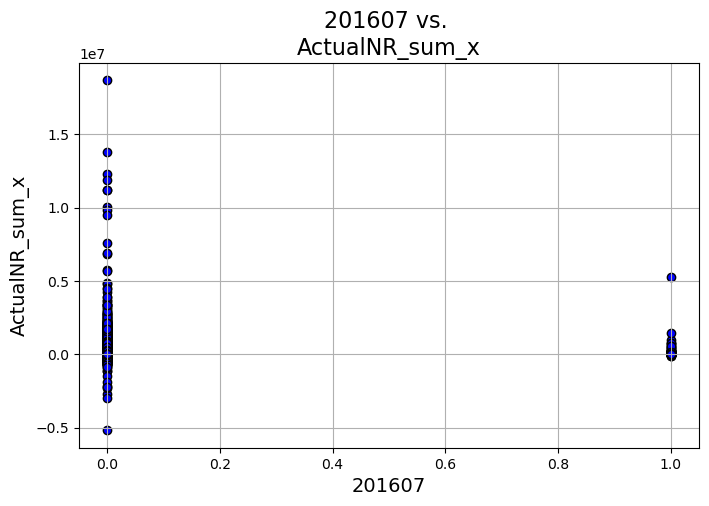

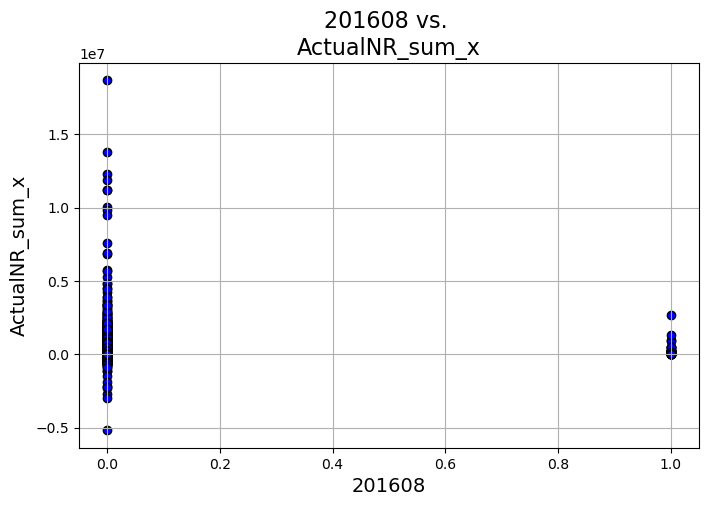

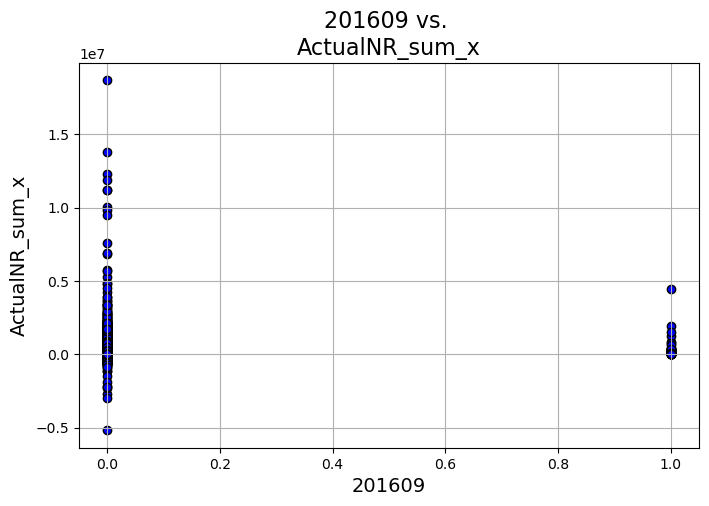

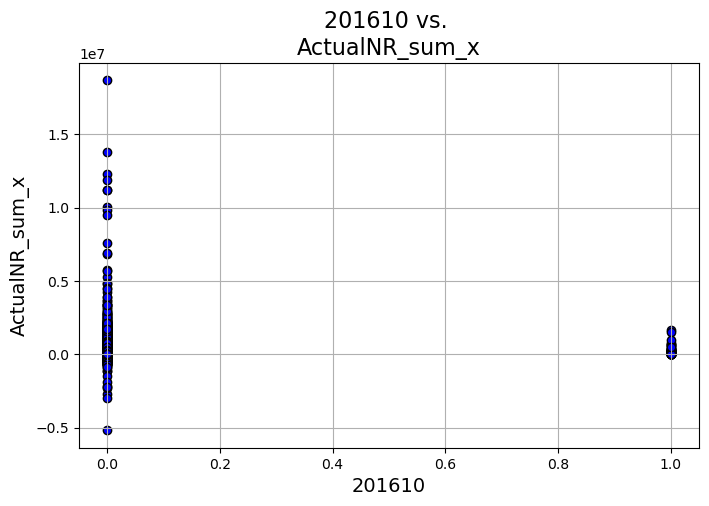

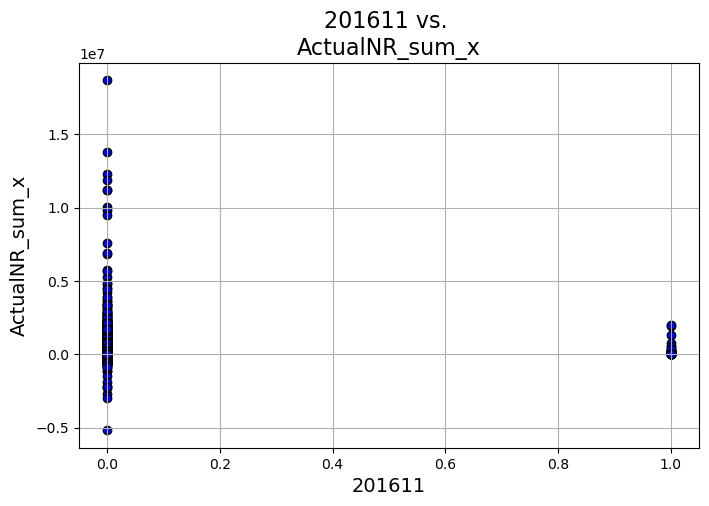

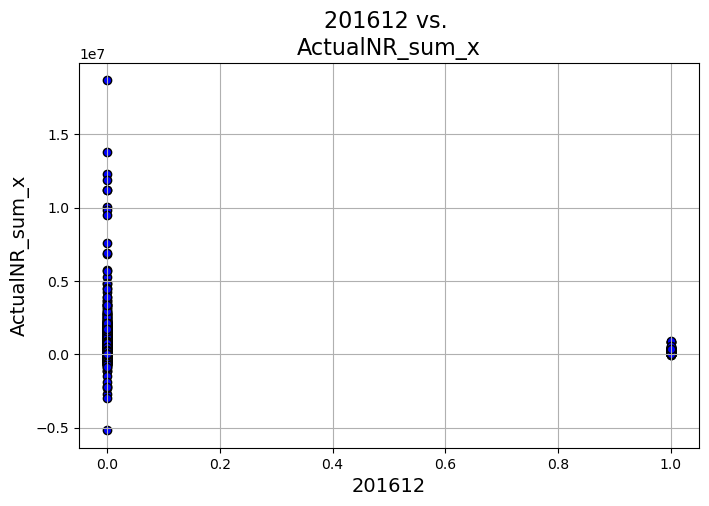

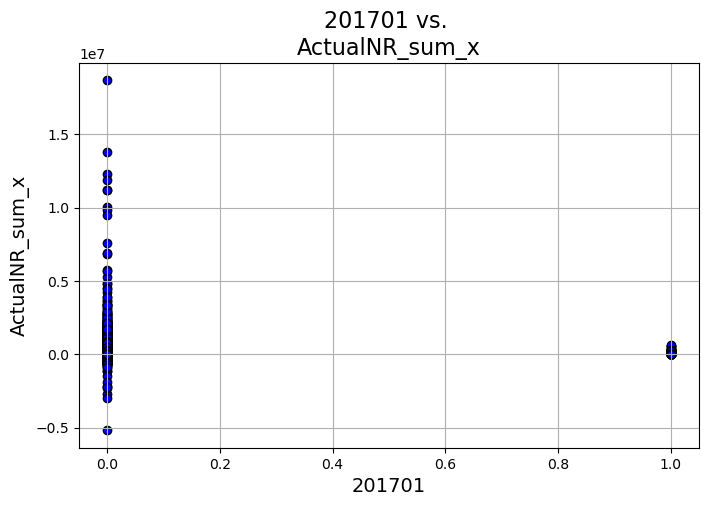

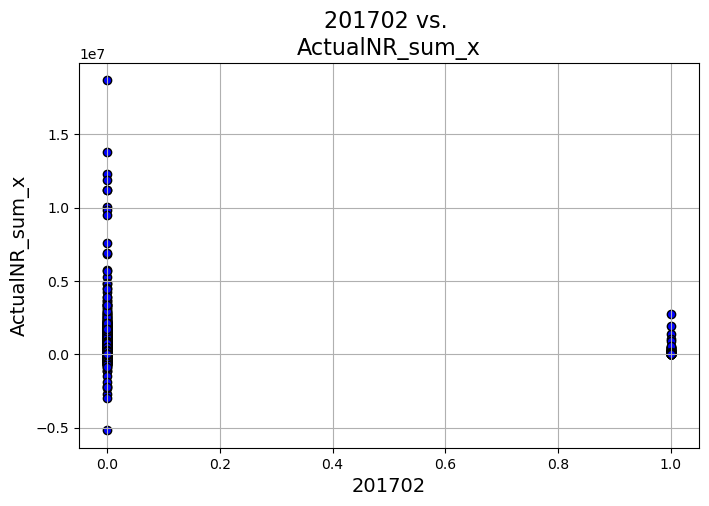

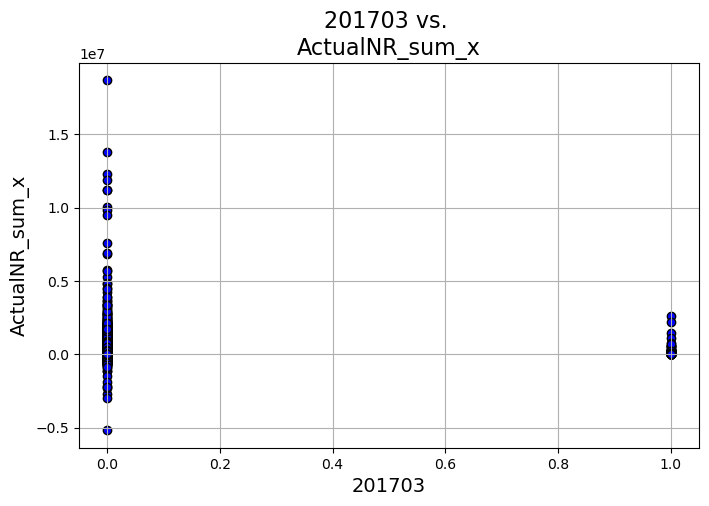

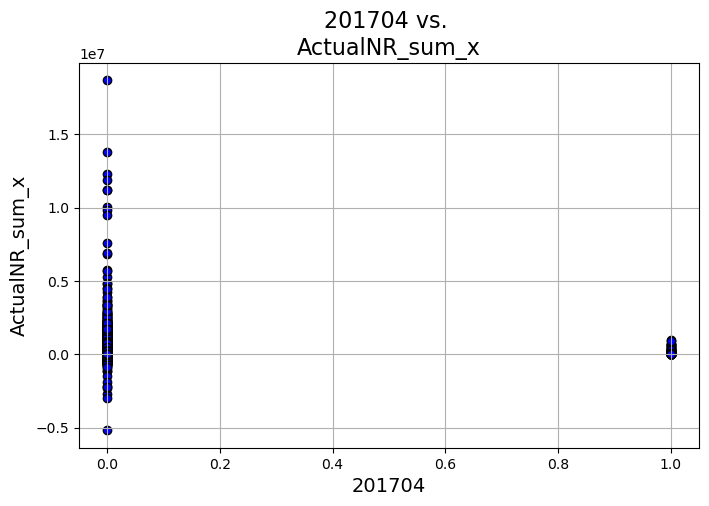

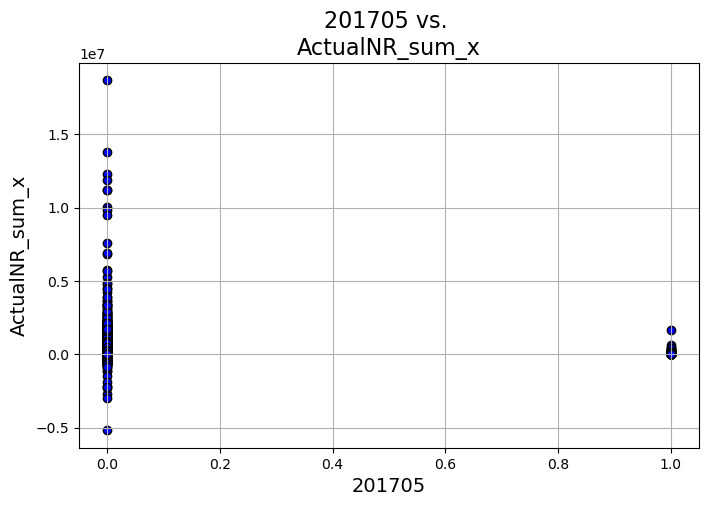

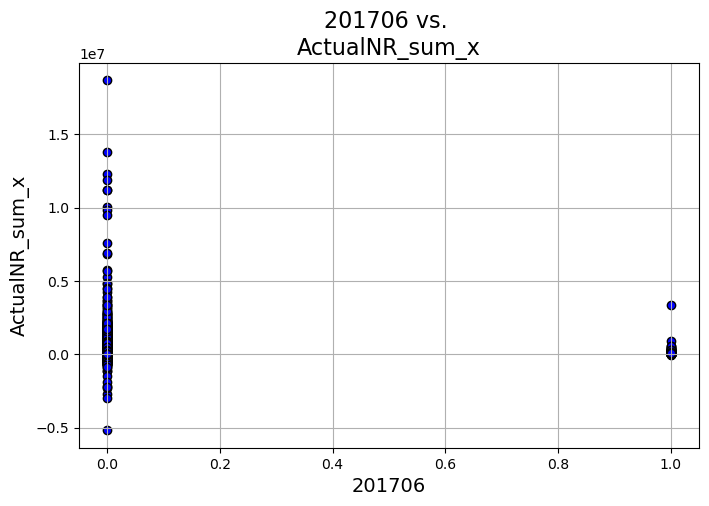

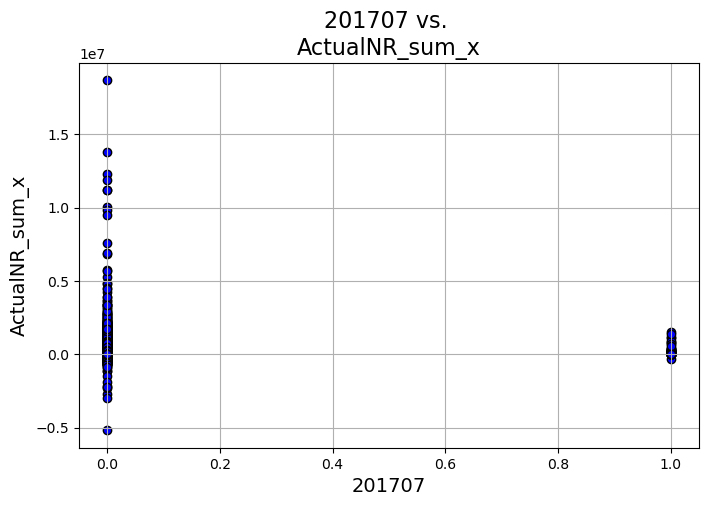

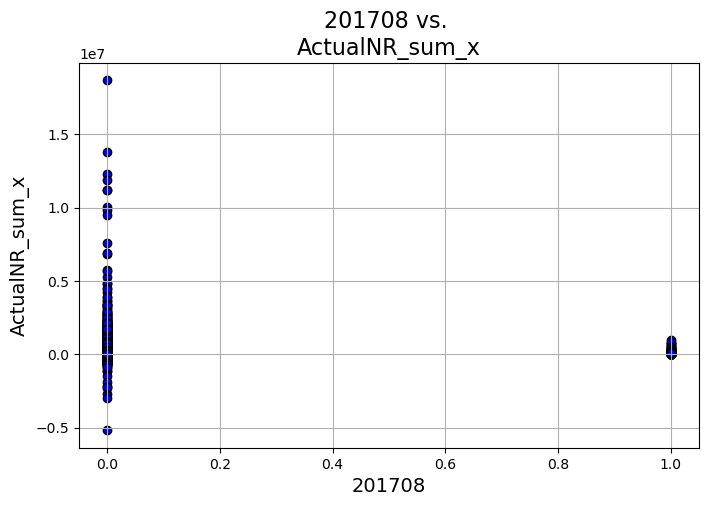

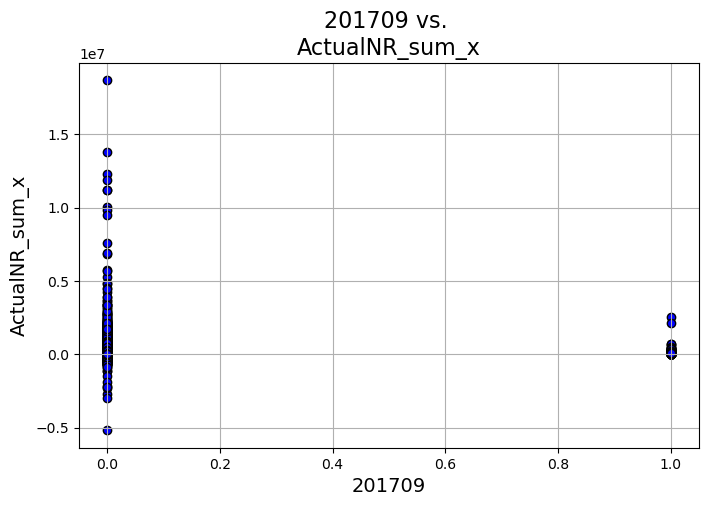

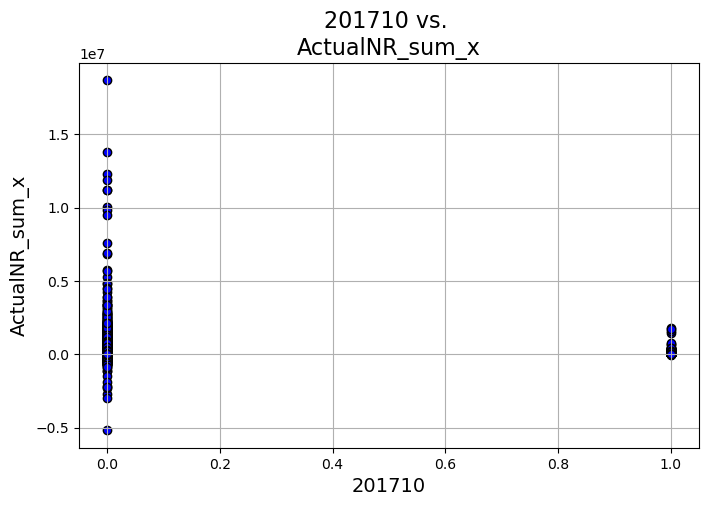

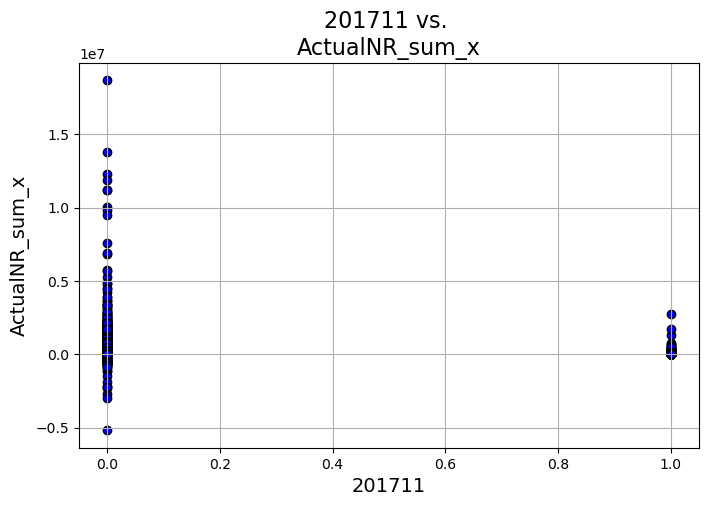

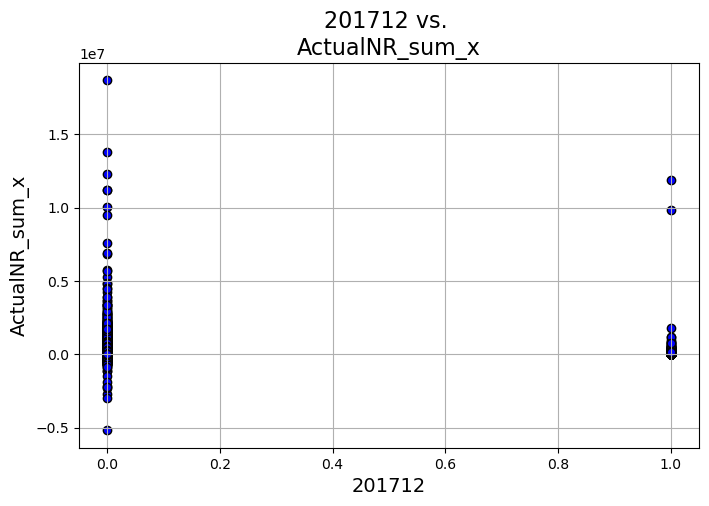

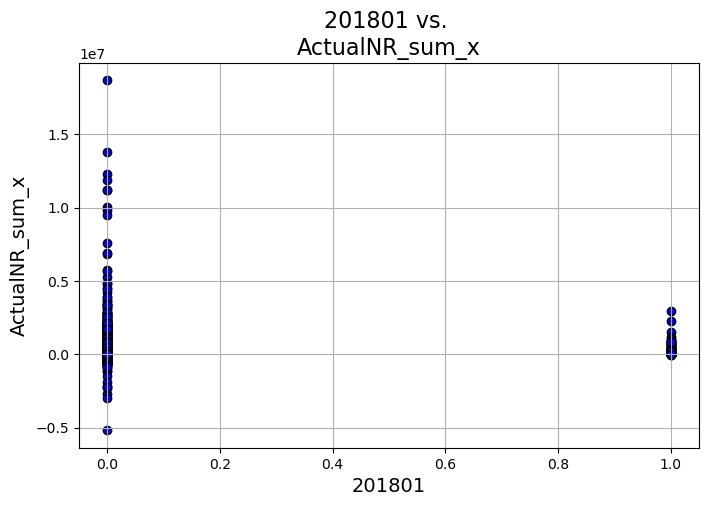

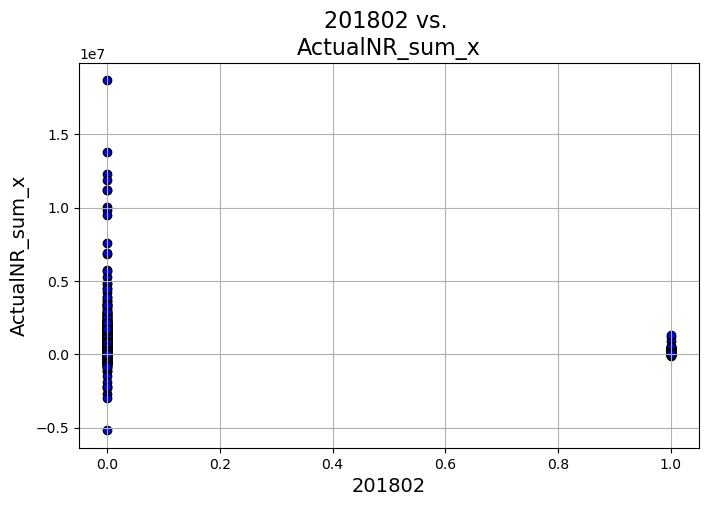

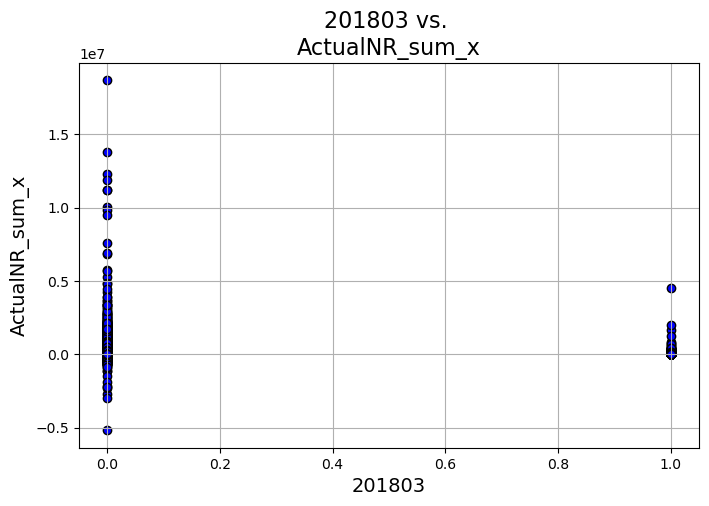

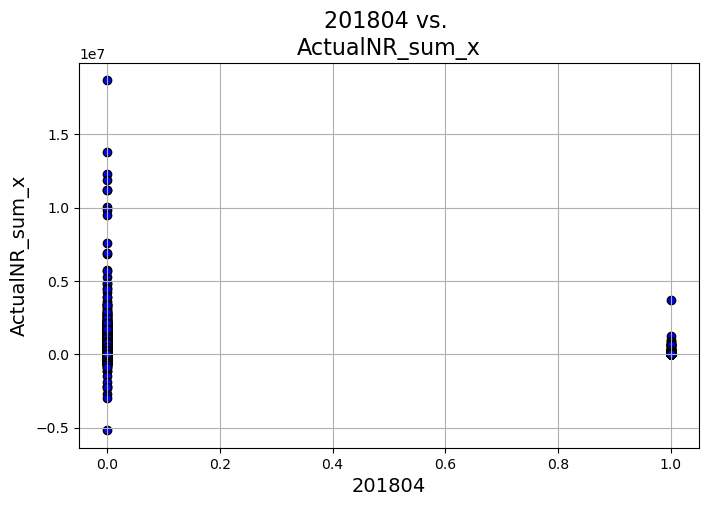

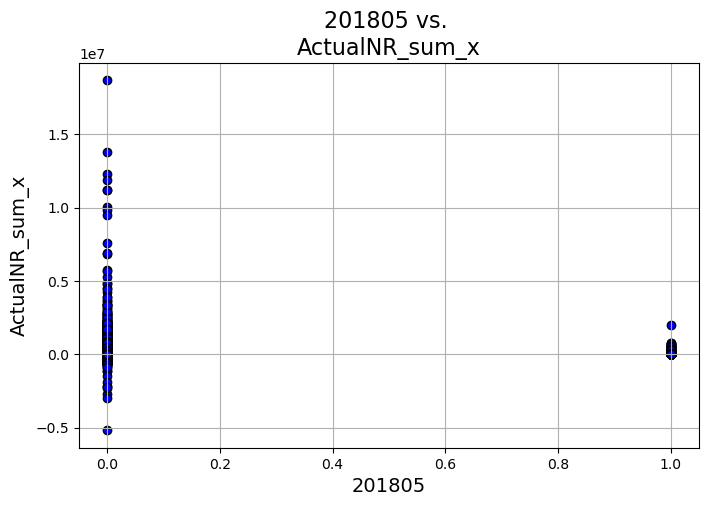

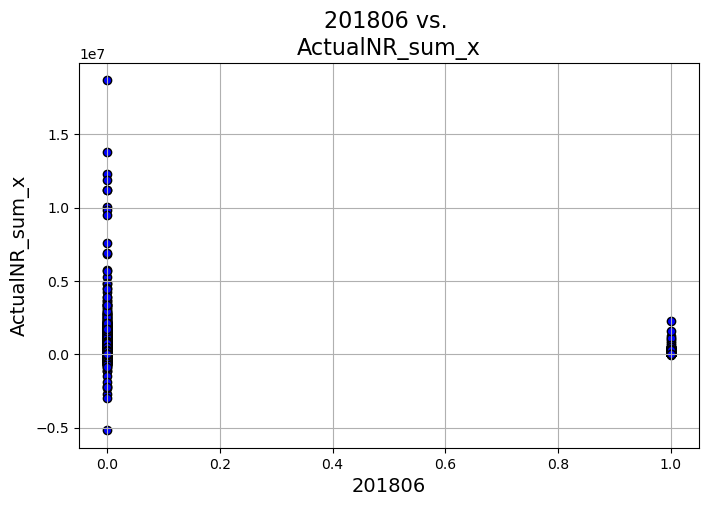

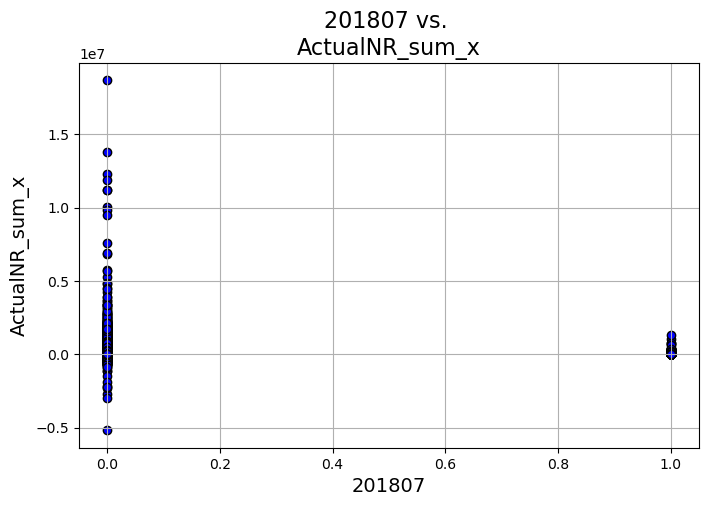

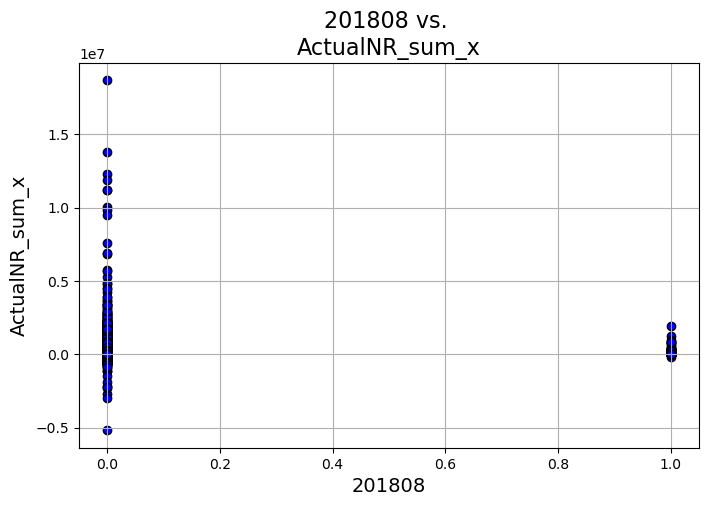

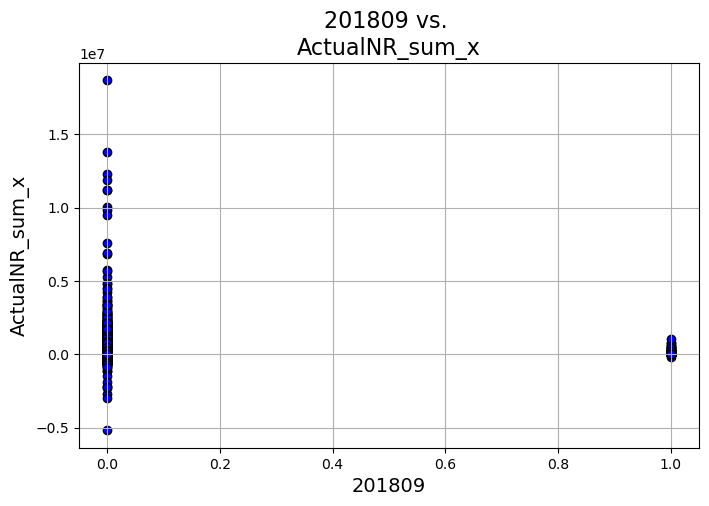

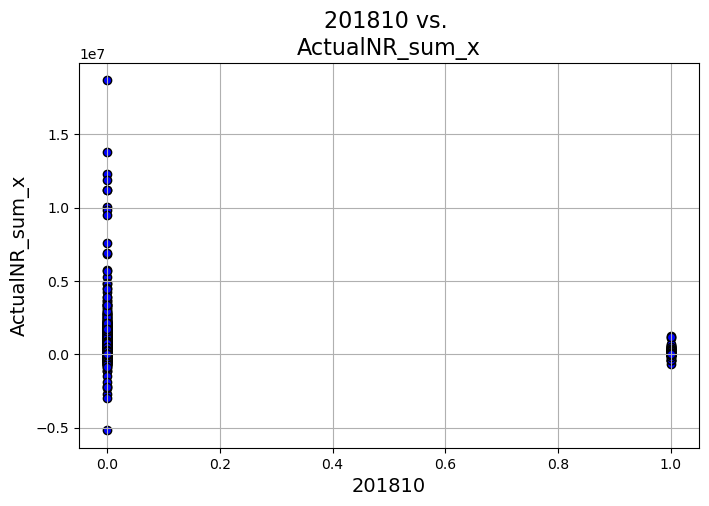

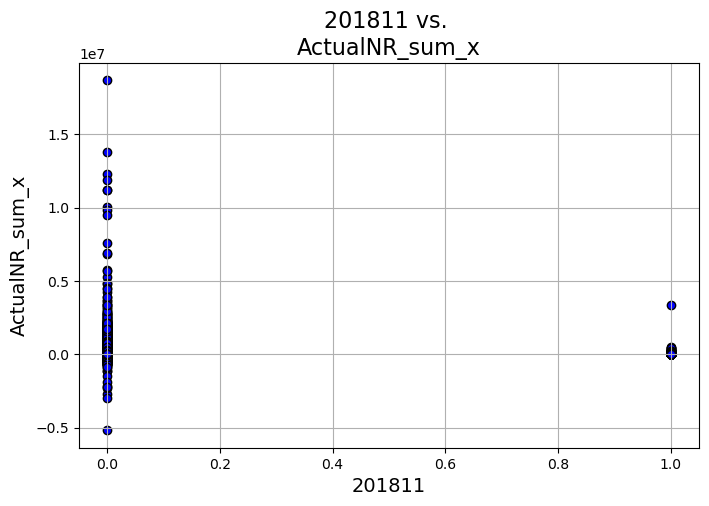

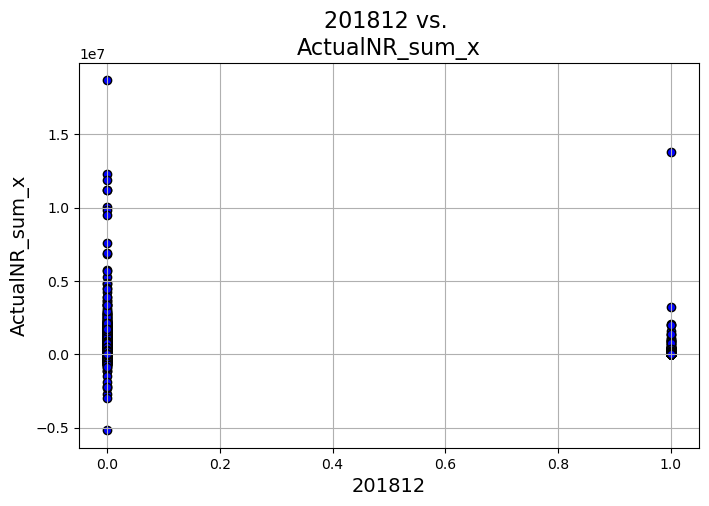

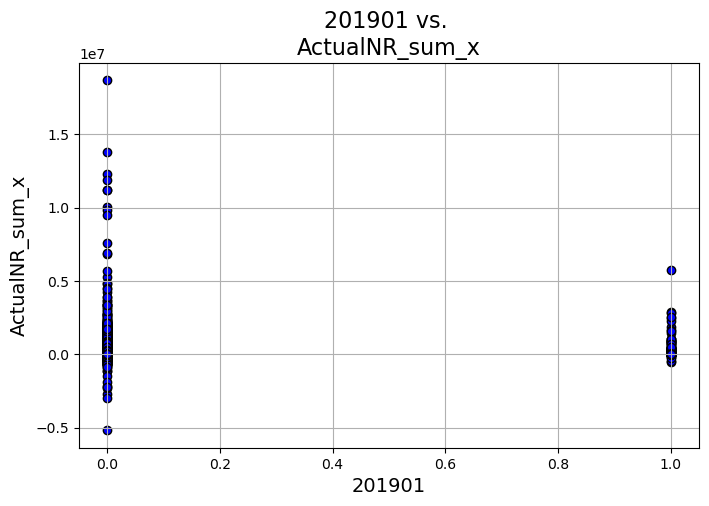

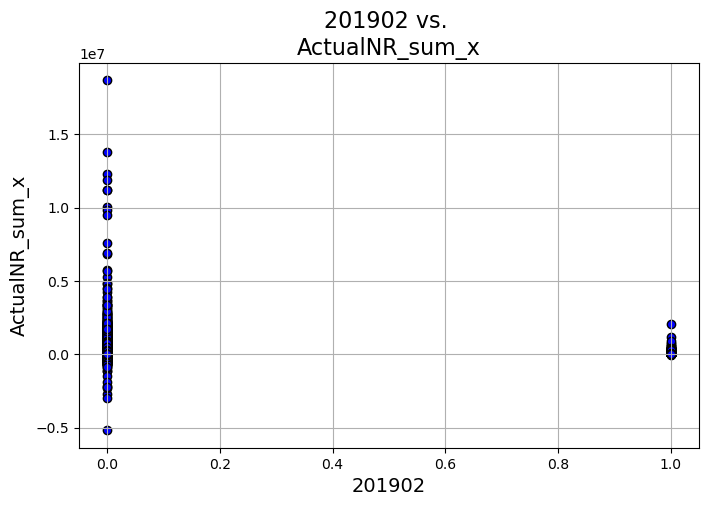

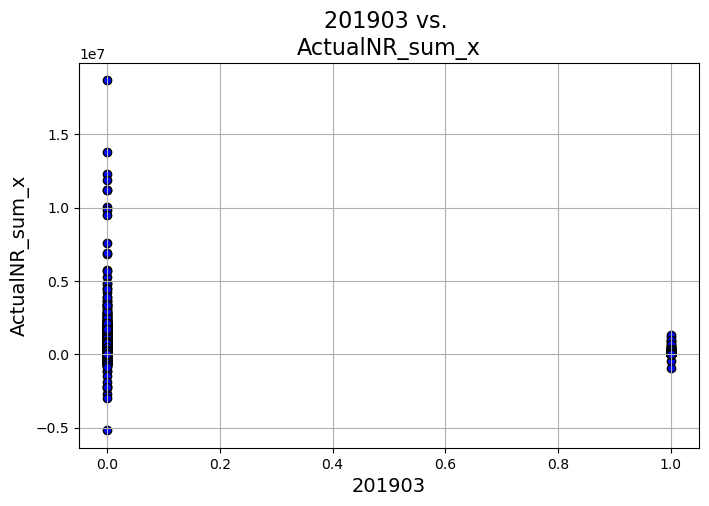

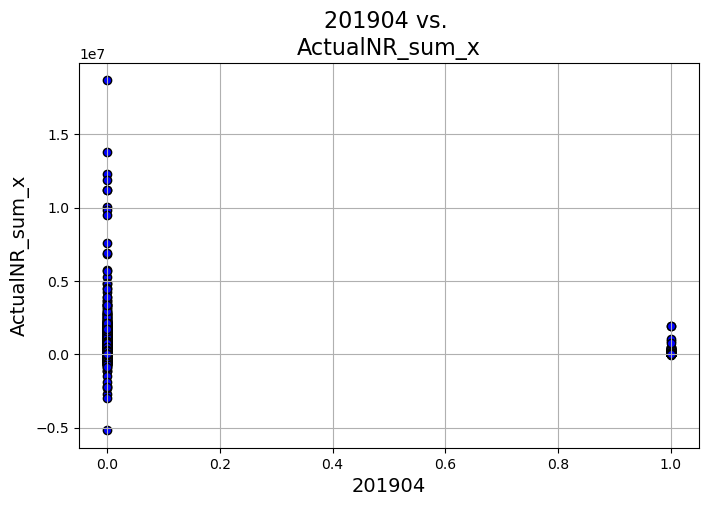

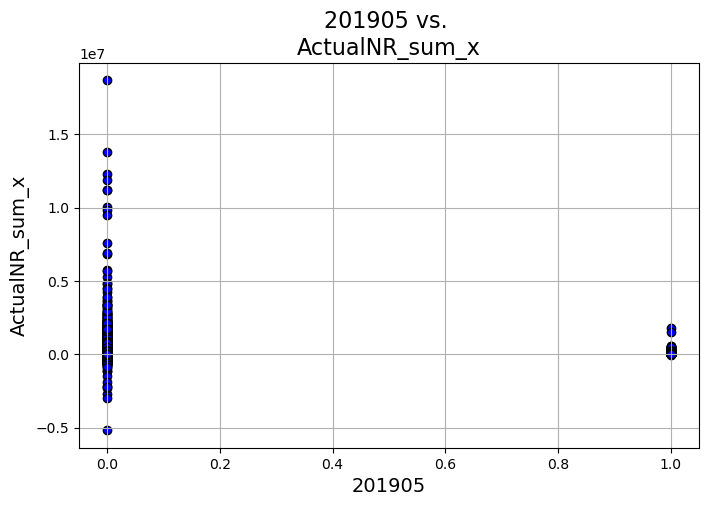

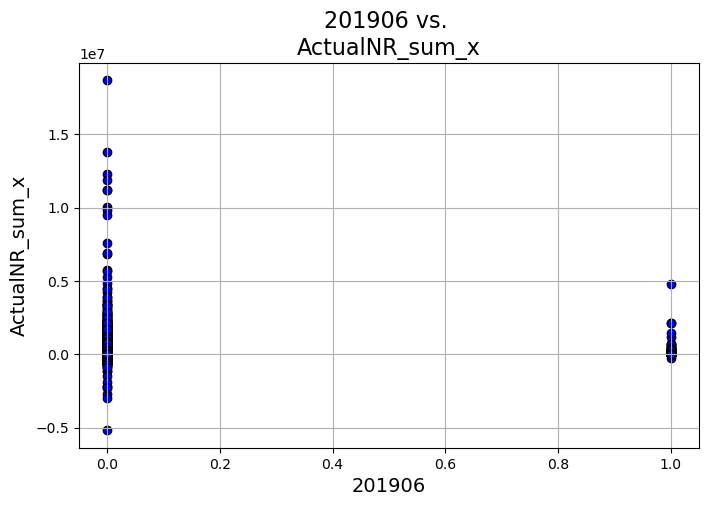

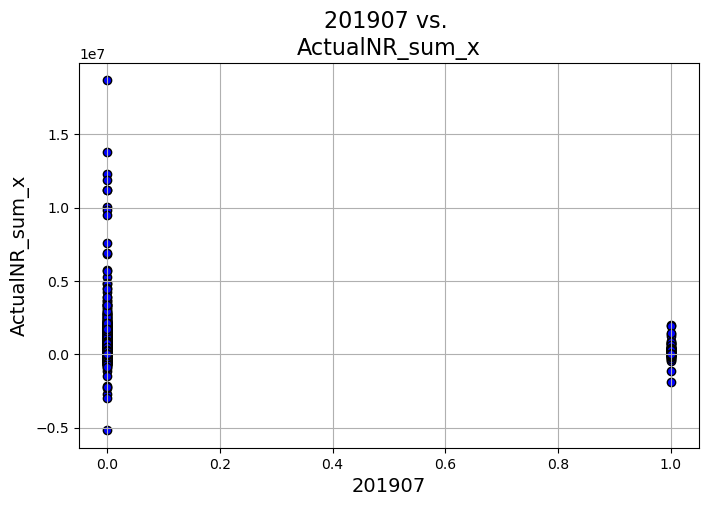

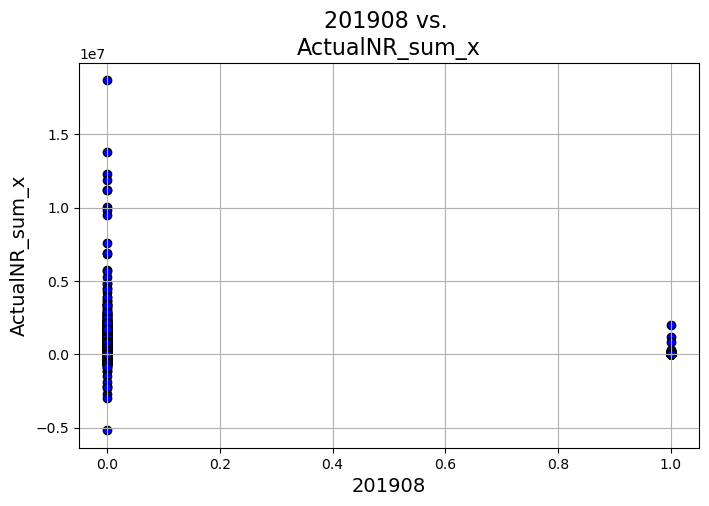

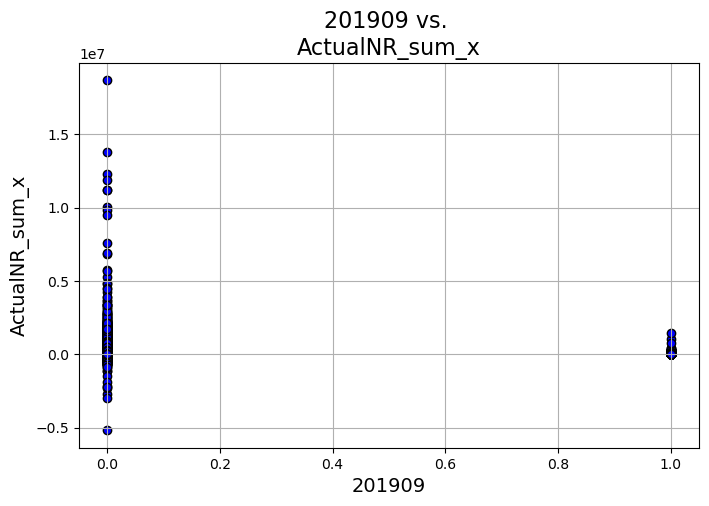

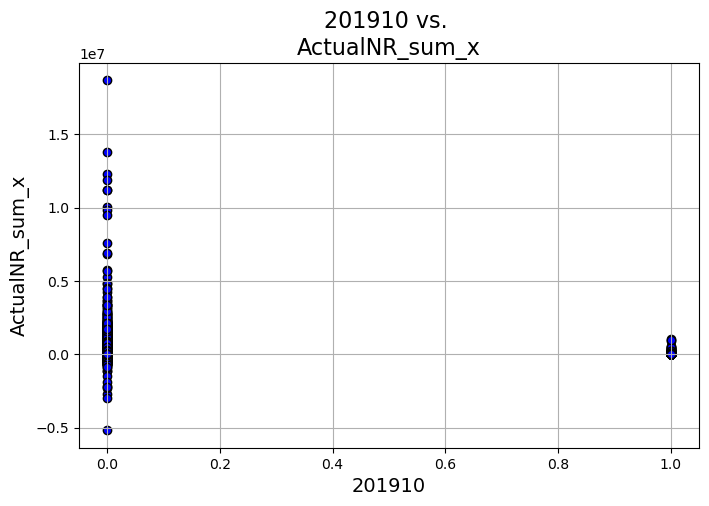

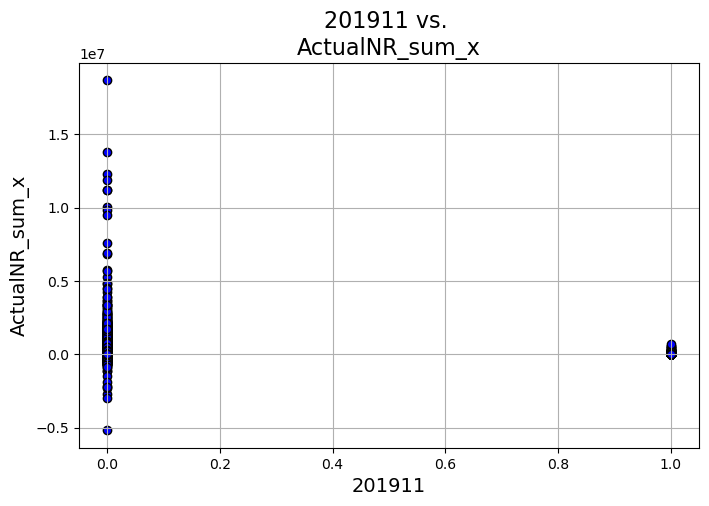

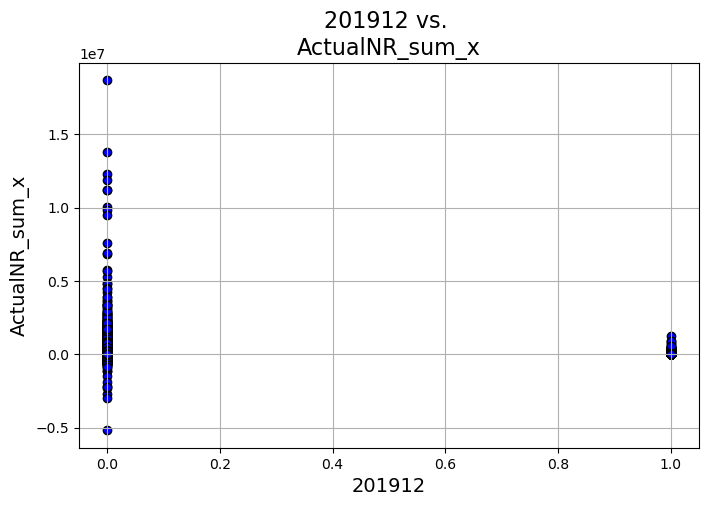

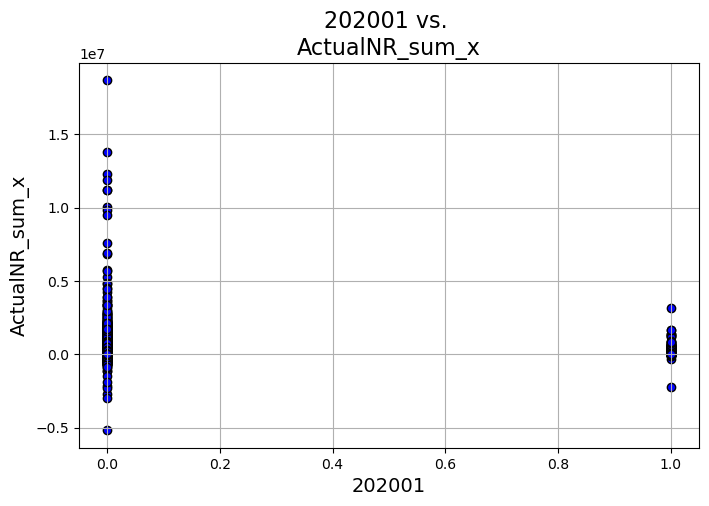

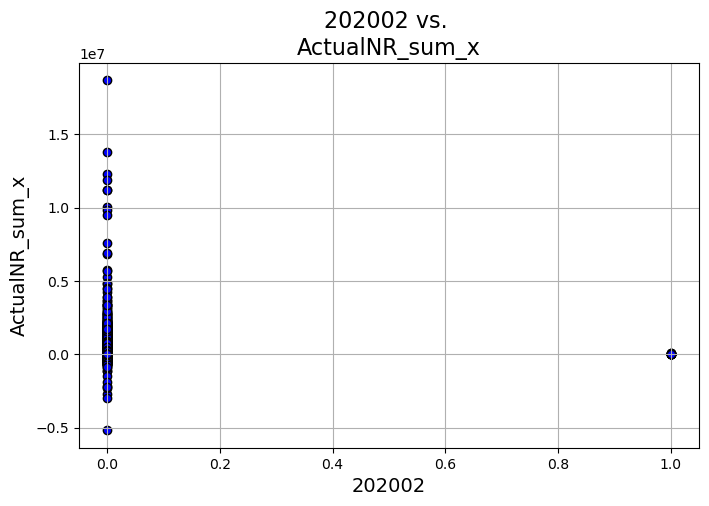

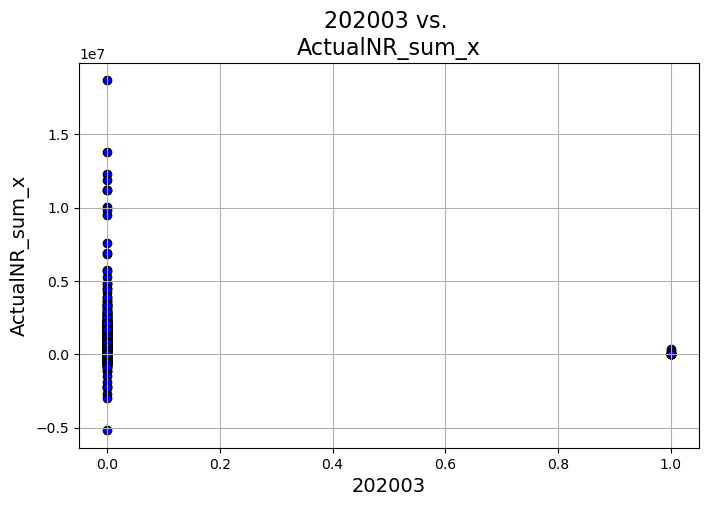

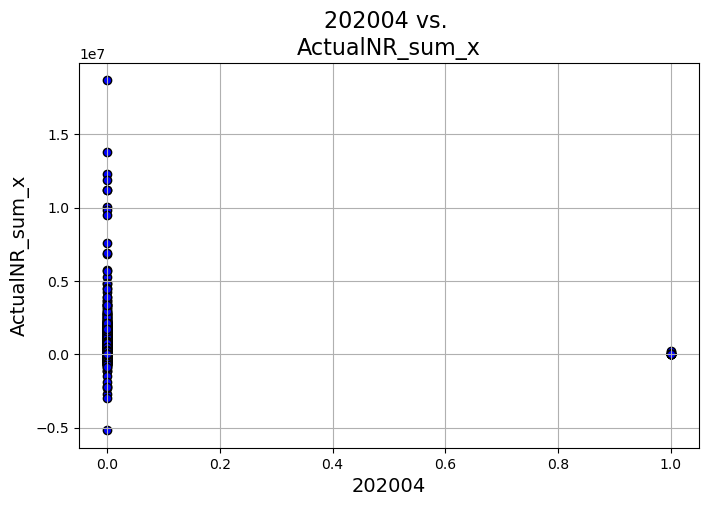

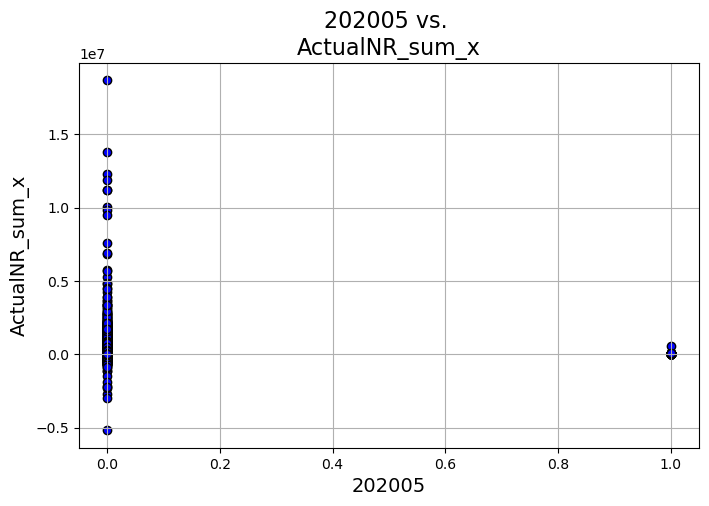

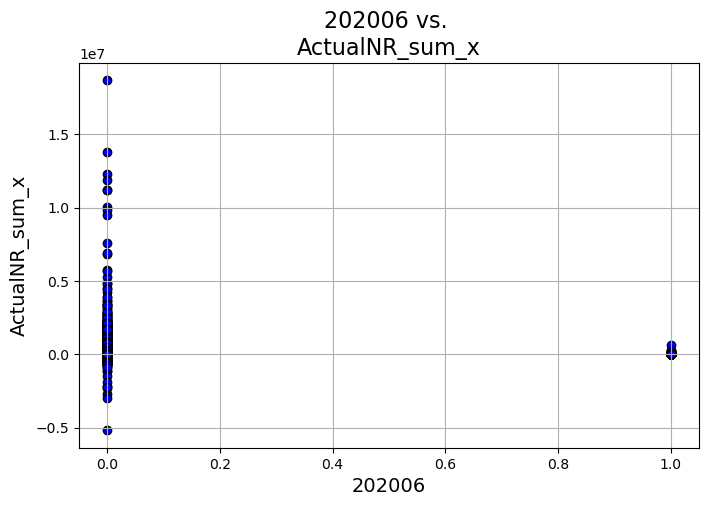

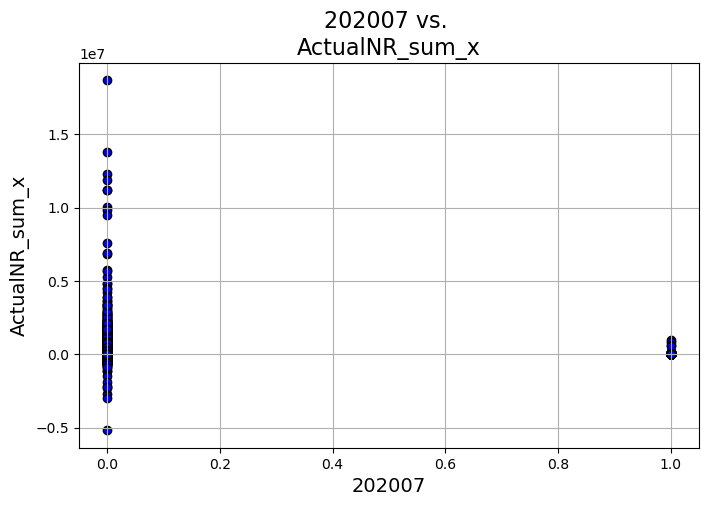

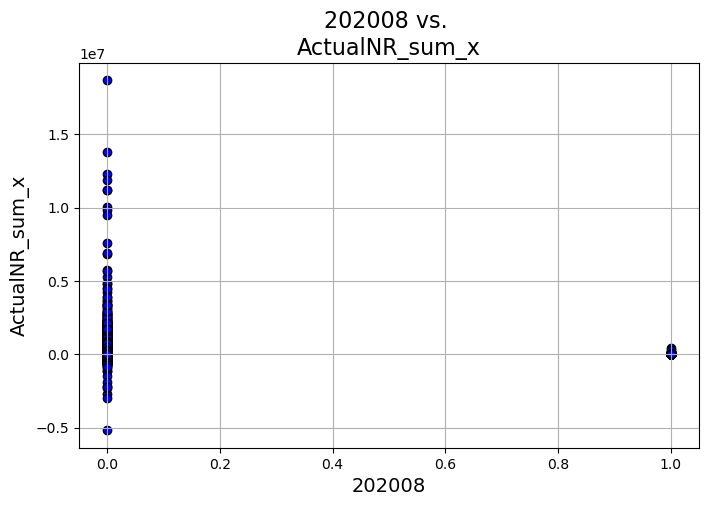

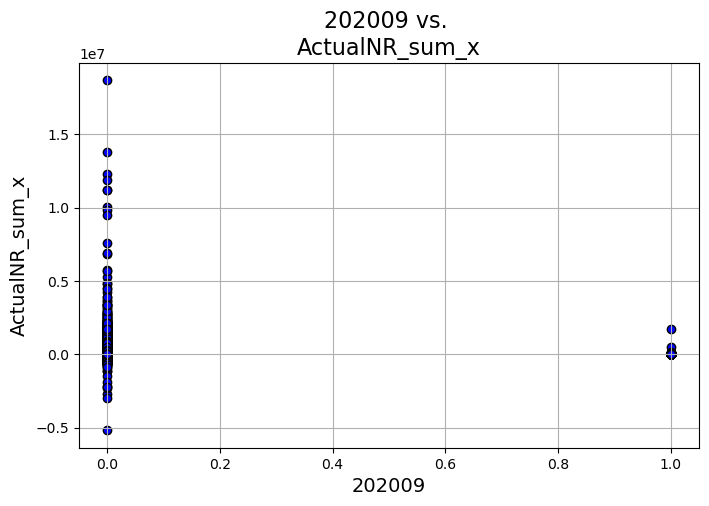

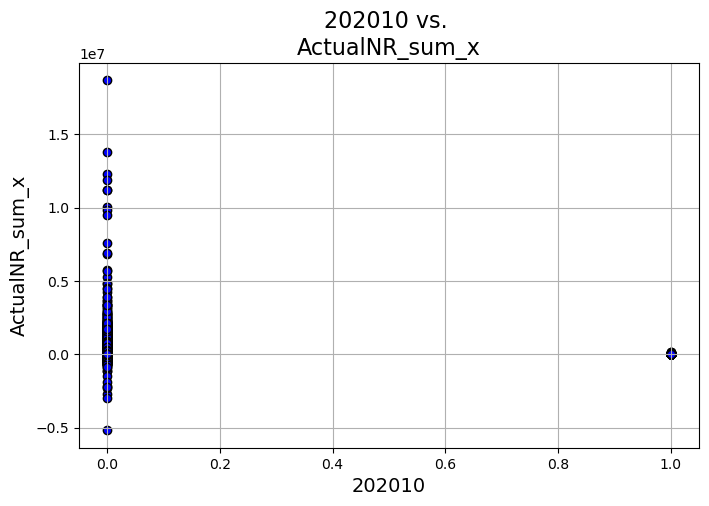

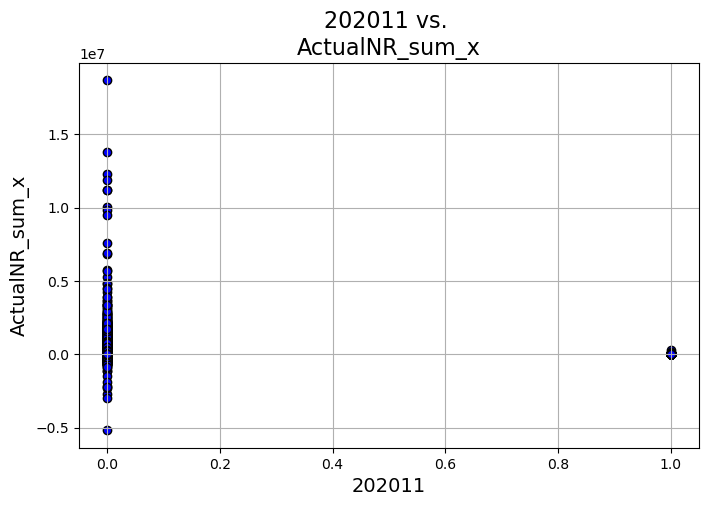

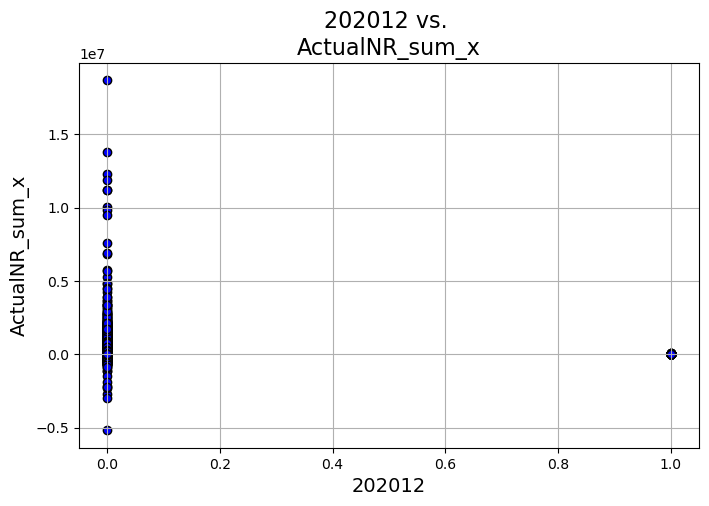

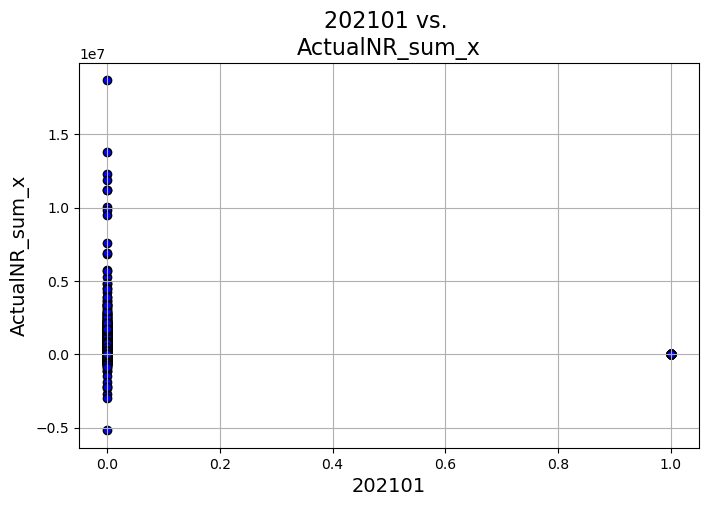

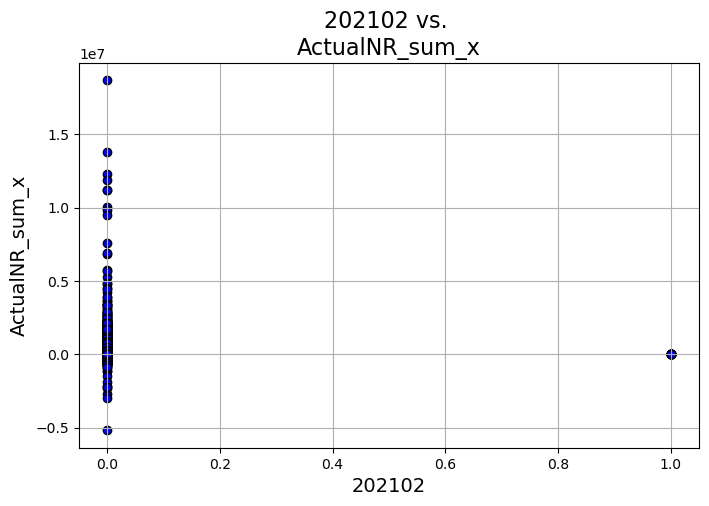

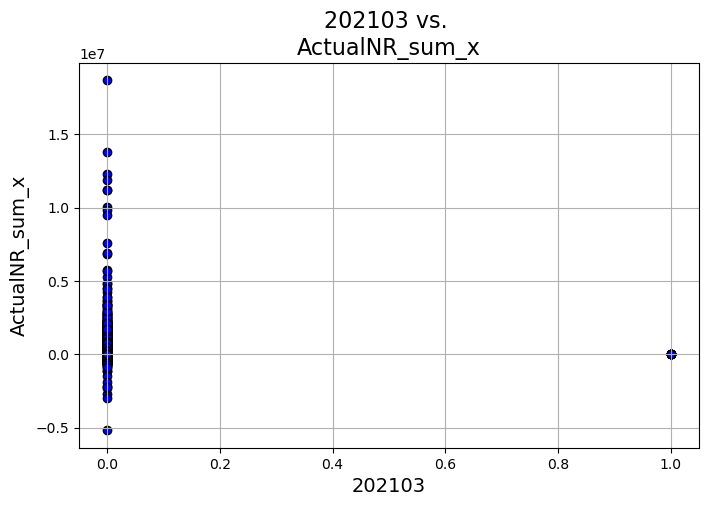

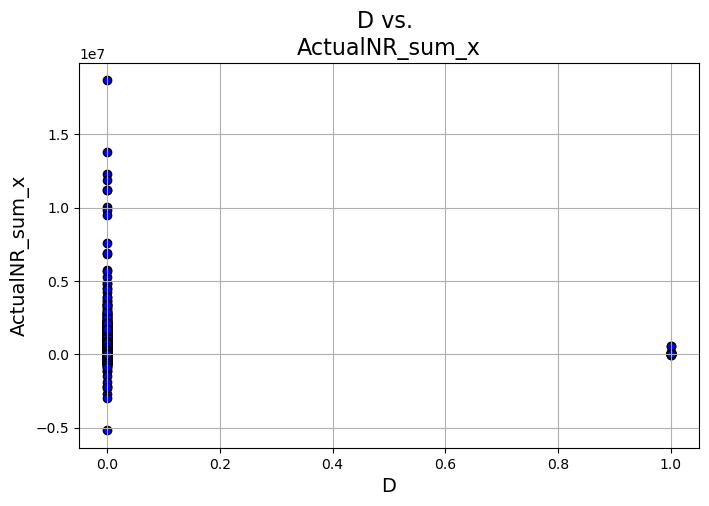

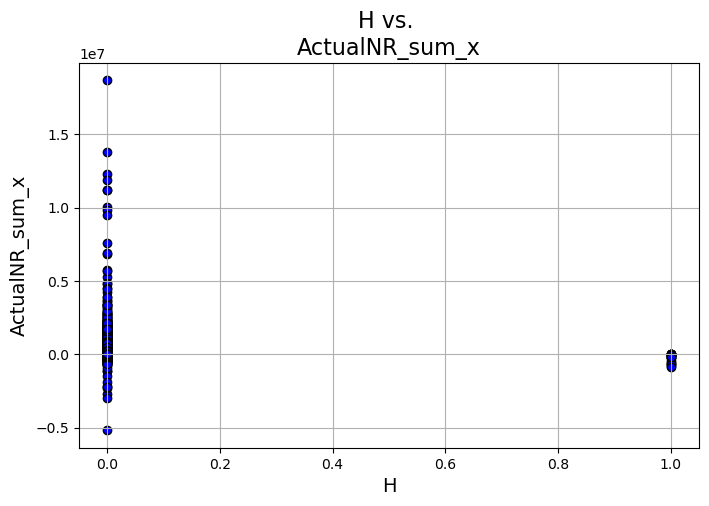

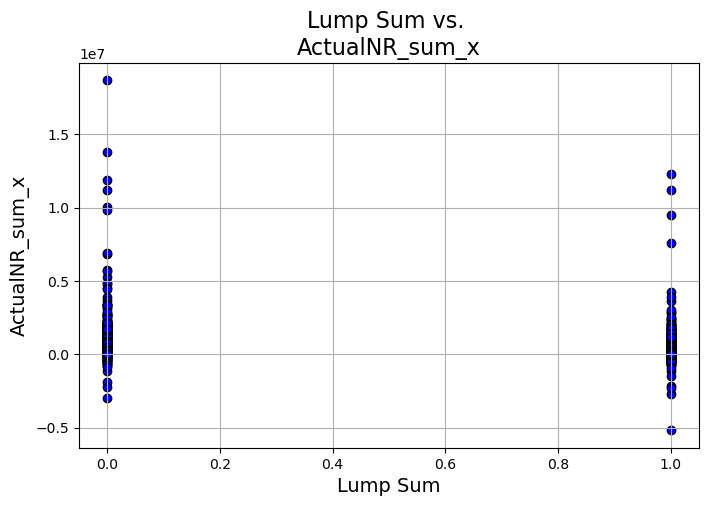

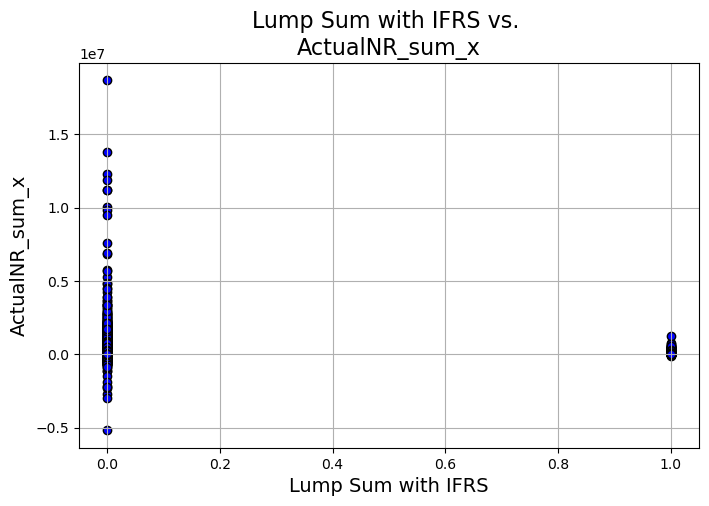

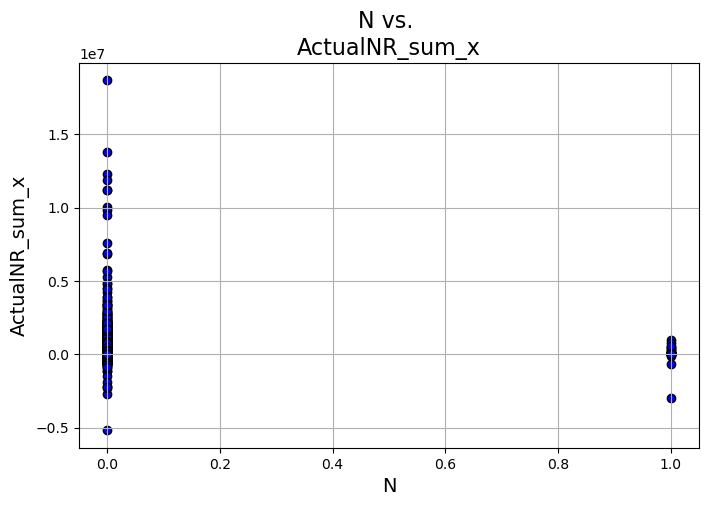

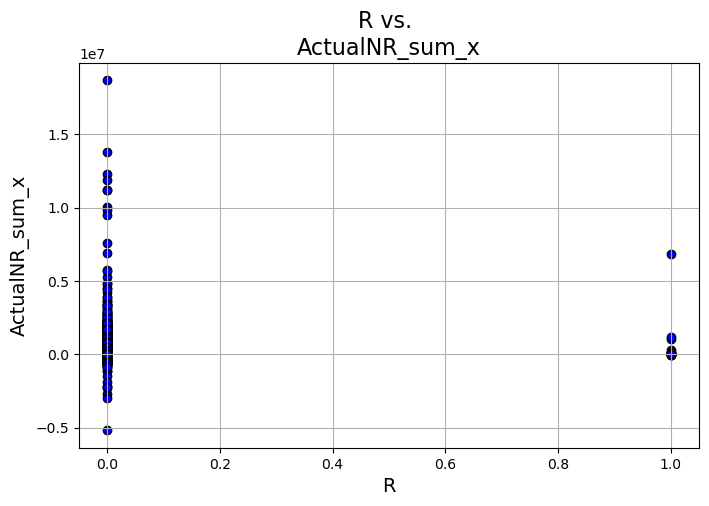

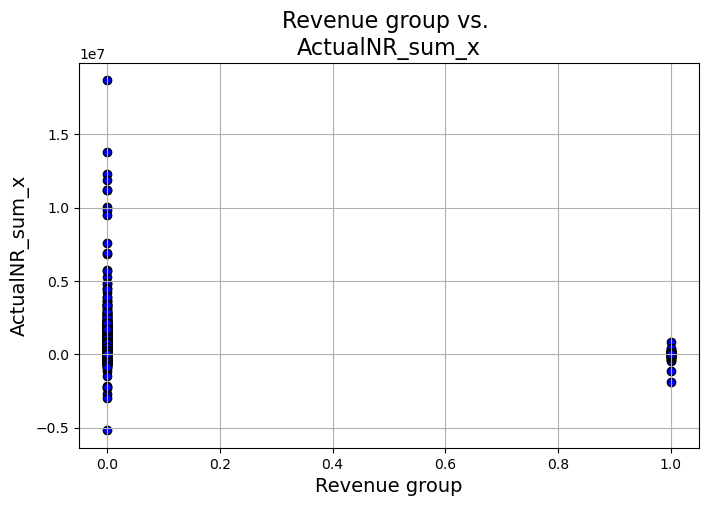

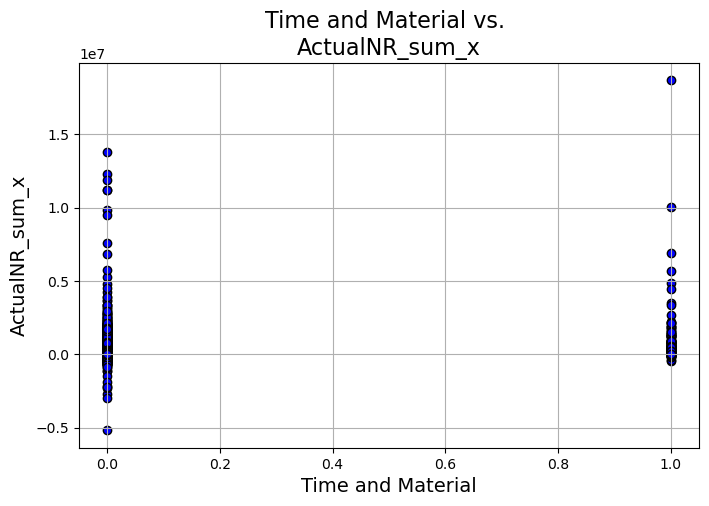

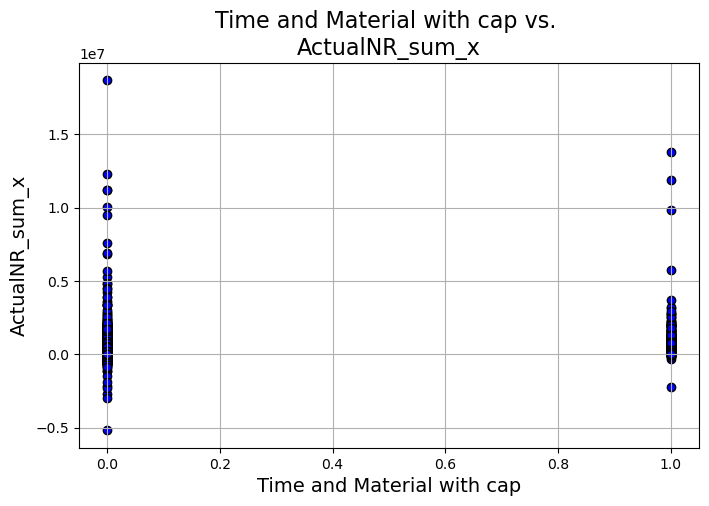

ValueError: x and y must be the same size

In [32]:
for c in df_actualNR.columns[:-1]:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \nActualNR_sum_x".format(c),fontsize=16)
    plt.scatter(x=df_actualNR[c],y=df_actualNR['ActualNR_sum_x'],color='blue',edgecolor='k')
    plt.grid(True)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('ActualNR_sum_x',fontsize=14)
    plt.show()

In [20]:
#No Mulitcollinearity
#generate correlation matrix
corr = X.corr()

#Homoscedasticity

In [21]:
corr

,Actual Net Revenue - MTD,Funding Amount - ITC (Snapshot),Backlog NR,Actual Direct Labor Cost - MTD,Actual Non-Labor Cost - MTD,Actual Gross Revenue - MTD,EBITA - MTD,Forecast Direct Labor Cost - ITC,Forecast Net Revenue - ITC,Order Intake (NR) - MTD,...,Transp/Log,Key Global,Key Local,Key Regional,Local,RKC,Unspecified,Low,Medium,Unspecified
Actual Net Revenue - MTD,1.000000,0.035290,-0.101818,0.794245,0.002138,0.951745,0.715934,0.035865,0.036690,0.070432,...,-0.006069,-0.021355,0.000293,-0.005051,0.018811,0.009656,-0.013822,-0.014377,0.001733,0.017313
Funding Amount - ITC (Snapshot),0.035290,1.000000,0.652451,0.051813,0.000978,0.060062,-0.001190,0.823120,0.845164,0.166397,...,-0.027173,0.000755,0.012264,0.020260,0.026257,0.026105,-0.058454,-0.039986,0.036869,-0.020518
Backlog NR,-0.101818,0.652451,1.000000,-0.114225,-0.000714,-0.106017,-0.033081,0.576643,0.613356,0.401619,...,-0.024586,-0.021415,-0.004066,-0.020345,0.021644,0.041940,-0.053725,-0.027700,0.013637,0.003092
Actual Direct Labor Cost - MTD,0.794245,0.051813,-0.114225,1.000000,0.004632,0.864408,0.144776,0.053891,0.052816,0.077128,...,-0.009702,-0.008620,0.000529,-0.000352,0.021088,0.007849,-0.020464,-0.020649,0.005222,0.020406
Actual Non-Labor Cost - MTD,0.002138,0.000978,-0.000714,0.004632,1.000000,0.208496,-0.001788,0.000053,0.000083,0.000873,...,-0.003124,0.005093,-0.000129,0.043007,-0.009362,-0.010433,0.003365,0.005902,0.001285,-0.009154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RKC,0.009656,0.026105,0.041940,0.007849,-0.010433,0.007523,0.006851,0.021507,0.023505,0.050142,...,0.168570,-0.105314,-0.038927,-0.119003,-0.330775,1.000000,-0.286912,-0.082846,-0.120146,0.274749
Unspecified,-0.013822,-0.058454,-0.053725,-0.020464,0.003365,-0.014925,0.000901,-0.050970,-0.053780,-0.070781,...,0.092335,-0.113821,-0.042071,-0.128615,-0.357493,-0.286912,1.000000,0.091067,0.090955,-0.250358
Low,-0.014377,-0.039986,-0.027700,-0.020649,0.005902,-0.014553,0.000837,-0.046344,-0.050148,-0.037062,...,0.063855,-0.055465,-0.010285,0.047783,-0.065972,-0.082846,0.091067,1.000000,-0.628155,-0.490527
Medium,0.001733,0.036869,0.013637,0.005222,0.001285,0.000093,-0.003694,0.049032,0.054012,0.028060,...,-0.007066,0.071032,0.040450,0.043907,0.043839,-0.120146,0.090955,-0.628155,1.000000,-0.262089


In [32]:
''' Lets do the split '''

from sklearn.model_selection import train_test_split

X = df_actualNR.iloc[:,1:]
y = df_actualNR.iloc[:,:1]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(21484, 287) (10583, 287) (21484, 1) (10583, 1)


In [37]:
# identify outliers with interquartile range
from numpy.random import seed
from numpy.random import randn
from numpy import percentile
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
X_train, y_train = X_train.loc[mask, :], y_train.loc[mask]

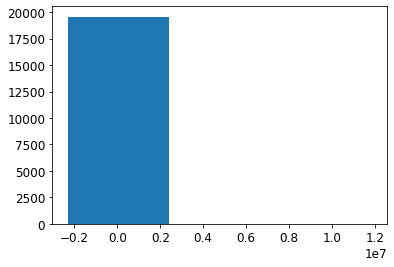

In [38]:
from numpy import exp
from numpy.random import randn
from sklearn.preprocessing import PowerTransformer
from matplotlib import pyplot


pyplot.hist(y_train, bins=3)
pyplot.show()

In [36]:
np.any(np.isnan(y))

False

In [43]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score


gbr = GradientBoostingRegressor() 
gbr.fit(X_train, y_train.values.ravel())
score_gbr_best = cross_val_score(gbr, X_train, y_train.values.ravel(), cv=5)
y_predict = gbr.predict(X_test)


print(score_gbr_best.mean())
print(gbr.score(X_test, y_test))

0.5832242529563694
0.5022915051260828


In [18]:
y_test = y_test.to_numpy()

In [44]:
importance = gbr.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.01051
Feature: 1, Score: 0.02656
Feature: 2, Score: 0.29066
Feature: 3, Score: 0.01584
Feature: 4, Score: 0.00266
Feature: 5, Score: 0.01031
Feature: 6, Score: 0.00491
Feature: 7, Score: 0.00718
Feature: 8, Score: 0.01968
Feature: 9, Score: 0.18171
Feature: 10, Score: 0.26087
Feature: 11, Score: 0.00081
Feature: 12, Score: 0.02065
Feature: 13, Score: 0.01256
Feature: 14, Score: 0.00188
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00013
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00009
Fe

In [39]:
import matplotlib.pyplot as plt

def plotGraph(y_test,y_pred,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(y_pred)), y_pred, color='orange')
    plt.title(regressorName)
    plt.show()
    return

In [113]:
plotGraph(y_test, y_predict, gbr)

NameError: name 'y_predict' is not defined

In [20]:
# set up Grid Search CV for Gradient Boosting
from sklearn.model_selection import GridSearchCV

gbr_grid = {'max_depth': [1,2,3,4,5]}

grid_gbr = GridSearchCV(estimator=gbr,param_grid=gbr_grid, cv=5, n_jobs=-1)

# fit combinations
grid_gbr.fit(X_train, y_train.values.ravel())

grid_gbr.best_params_

{'max_depth': 4}

In [22]:
print((df_actualNR.columns.tolist()))

['ActualNR_sum_x', 'Actual Net Revenue - MTD', 'Funding Amount - ITC (Snapshot)', 'Backlog NR', 'Actual Direct Labor Cost - MTD', 'Actual Non-Labor Cost - MTD', 'Actual Gross Revenue - MTD', 'EBITA - MTD', 'Forecast Direct Labor Cost - ITC', 'Forecast Net Revenue - ITC', 'Order Intake (NR) - MTD', 'Baseline NR', 'riskrating_project', 'scheduled_duration', 'Scheduled_projectduration', 'seasonality_month', 201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608, 201609, 201610, 201611, 201612, 201701, 201702, 201703, 201704, 201705, 201706, 201707, 201708, 201709, 201710, 201711, 201712, 201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812, 201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912, 202001, 202002, 202003, 202004, 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012, 202101, 202102, 202103, 'Cost plus Fixed Fee', 'H', 'Lump Sum', 'Lump Sum with IFRS', 'Revenue group', 'Time and

In [64]:
''' 
numeric = df_actualNR[['ActualNR_sum_x', 'Actual Net Revenue - MTD', 'Funding Amount - ITC (Snapshot)', 'Backlog NR', 'Actual Direct Labor Cost - MTD', 'Actual Non-Labor Cost - MTD', 'Actual Gross Revenue - MTD', 'EBITA - MTD', 'Forecast Direct Labor Cost - ITC', 'Forecast Net Revenue - ITC', 'Order Intake (NR) - MTD', 'Baseline NR', 'ADL_shifted', 'ANR_shifted', 'ANR_previous_year']]
                       
df_actualNR.pop('ActualNR_sum_x')
df_actualNR.pop('Actual Net Revenue - MTD')
df_actualNR.pop('Funding Amount - ITC (Snapshot)')
df_actualNR.pop('Backlog NR')

df_actualNR.pop('Actual Direct Labor Cost - MTD')
df_actualNR.pop('Actual Gross Revenue - MTD')
df_actualNR.pop('Actual Non-Labor Cost - MTD')

df_actualNR.pop('Forecast Direct Labor Cost - ITC')

df_actualNR.pop('Order Intake (NR) - MTD')
df_actualNR.pop('Baseline NR')

df_actualNR.pop('Forecast Net Revenue - ITC')
df_actualNR.pop('EBITA - MTD')

df_actualNR.pop('ADL_shifted')
df_actualNR.pop('ANR_shifted')
df_actualNR.pop('ANR_previous_year')


'''

0        69139513.09
1        69139513.09
2        69139513.09
3        69139513.09
4        69139513.09
            ...     
32062           0.00
32063    14713074.24
32064    18173033.02
32065    27053876.13
32066    36520831.03
Name: ANR_previous_year, Length: 32067, dtype: float64

In [65]:
''' Here we scale the numeric features

from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()
scaler.fit(numeric)  
numeric = scaler.transform(numeric)  


df_numeric=pd.DataFrame(numeric, columns=['ActualNR_sum_x', 'Actual Net Revenue - MTD', 'Funding Amount - ITC (Snapshot)', 'Backlog NR', 'Actual Direct Labor Cost - MTD', 'Actual Non-Labor Cost - MTD', 'Actual Gross Revenue - MTD', 'EBITA - MTD', 'Forecast Direct Labor Cost - ITC', 'Forecast Net Revenue - ITC', 'Order Intake (NR) - MTD', 'Baseline NR', 'ADL_shifted', 'ANR_shifted', 'ANR_previous_year'])

df_actual = pd.concat([df_numeric, df_actualNR], axis=1)

'''

In [176]:
from sklearn.model_selection import train_test_split

X = df_actualNR.iloc[:,1:]
y = df_actualNR.iloc[:,:1]

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(25653, 295) (6414, 295) (25653, 1) (6414, 1)


In [178]:
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
er = VotingRegressor([('rf', forest), ('gbr', gbr)])

er.fit(X_train, y_train.values.ravel())

score_er_best = cross_val_score(er, X_train, y_train.values.ravel(), cv=5)
print(score_er_best.mean())
print(er.score(X_test, y_test))

0.5169430288976047
0.6328039731281261


In [179]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

yhat=er.predict(X_test)

r2score=r2_score(y_test, yhat)
print(r2score)

mse=mean_squared_error(yhat, y_test)

import numpy as np
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
print('The normalized Root Mean Squared Error of our forecasts is {}'.format( (round(np.sqrt(mse), 2))/ ((y_test.max() - y_test.min())* 100)))

0.6328039731281261
The Mean Squared Error of our forecasts is 41502286190.12
The Root Mean Squared Error of our forecasts is 203721.1
The normalized Root Mean Squared Error of our forecasts is ActualNR_sum_x    0.000085
dtype: float64


In [98]:
!pip install lightgbm

     |████████████████████████████████| 1.2 MB 7.6 MB/s eta 0:00:01


In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train.values.ravel())
dteast = xgb.DMatrix(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score

forest = RandomForestRegressor()
forest.fit(X_train, y_train.values.ravel())
score_forest_best = cross_val_score(forest, X_train, y_train.values.ravel(), cv=5)
print(score_forest_best.mean())
print(forest.score(X_test, y_test))

In [117]:
importance = forest.feature_importances_
for i,v in enumerate(importance):
    if v > 0.01:
        print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.01406
Feature: 1, Score: 0.03410
Feature: 2, Score: 0.18679
Feature: 3, Score: 0.01975
Feature: 5, Score: 0.02199
Feature: 6, Score: 0.01742
Feature: 10, Score: 0.02109
Feature: 11, Score: 0.02850
Feature: 12, Score: 0.06905
Feature: 13, Score: 0.38210
Feature: 15, Score: 0.01409
Feature: 16, Score: 0.01323
Feature: 42, Score: 0.01014
Feature: 236, Score: 0.02064


In [122]:
X_test.iloc[:,0:15]

,Actual Net Revenue - MTD,Funding Amount - ITC (Snapshot),Backlog NR,Actual Direct Labor Cost - MTD,Actual Non-Labor Cost - MTD,Actual Gross Revenue - MTD,EBITA - MTD,ADL_shifted,ANR_shifted,ANR_previous_year,Forecast Direct Labor Cost - ITC,Forecast Net Revenue - ITC,Order Intake (NR) - MTD,Baseline NR,riskrating_project
5351,0.00,15098,2945.00,0.00,0.0,0.00,0.00,2.453807e+07,6.702559e+07,69139513.09,4543.29,12788.20,-302.00,12788.20,0.0
13082,745.26,111883,96532.22,290.45,0.0,745.26,116.29,2.574377e+07,7.082296e+07,47877065.52,38247.59,97277.48,97277.48,92057.34,1.0
21249,0.00,78680,0.00,0.00,0.0,0.00,0.00,2.453807e+07,6.702559e+07,69139513.09,25909.99,0.00,0.00,0.00,0.0
15380,0.00,0,0.00,0.00,0.0,0.00,0.00,6.535312e+06,1.691376e+07,0.00,0.00,0.00,0.00,90623.66,0.0
760,0.00,7216,6586.00,0.00,0.0,0.00,0.00,2.557842e+07,7.028895e+07,58629306.14,2280.75,6586.00,6586.00,0.43,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6999,0.00,99090,81630.00,0.00,0.0,0.00,0.00,1.322915e+07,3.297292e+07,18173033.02,26756.86,81630.00,81630.00,216371.78,0.0
8568,1635.43,3400,1752.99,512.68,0.0,1635.43,375.88,2.079879e+07,5.755173e+07,36520831.03,1114.41,3388.42,3388.42,4269.58,1.0
13149,0.00,1975,0.00,0.00,0.0,0.00,0.00,2.309580e+07,6.430503e+07,48666667.76,510.65,1717.70,0.00,53748.86,0.0
1663,19392.38,181744,149085.15,7145.39,0.0,19577.50,1872.60,1.082843e+07,2.861349e+07,14713074.24,63126.81,168477.53,168477.53,139878.22,0.0


In [47]:
y_predict = forest.predict(X_test)

In [49]:
y_test = y_test.to_numpy()

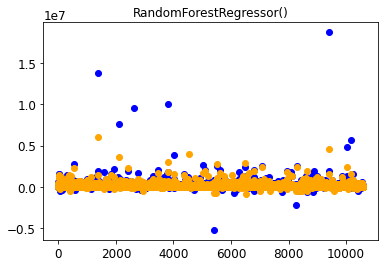

In [50]:
plotGraph(y_test, y_predict, forest)

In [53]:
df_actualNR.iloc[:, 0:12]

,ActualNR_sum_x,Actual Net Revenue - MTD,Funding Amount - ITC (Snapshot),Backlog NR,Actual Direct Labor Cost - MTD,Actual Non-Labor Cost - MTD,Actual Gross Revenue - MTD,EBITA - MTD,Forecast Direct Labor Cost - ITC,Forecast Net Revenue - ITC,Order Intake (NR) - MTD,Baseline NR
0,21839,2900.00,733572,92293.61,1276.25,0.00,2900.00,-111.9500,59406.75,202204.76,-9038.23,193166.53
1,9093,0.00,97237,0.00,757.88,2700.00,2700.00,-1788.5968,7470.32,-12669.36,0.00,10913.66
2,-5175,397.50,386461,0.00,277.66,0.00,397.50,-257.7776,33602.16,87626.98,397.48,88024.46
3,1177,706.50,22500,942.00,220.50,0.00,706.50,186.1200,7648.35,22491.99,0.00,22491.99
4,13458,817.24,50676,0.00,537.55,14.92,832.16,-451.3780,13062.48,25969.26,-7304.46,28877.52
...,...,...,...,...,...,...,...,...,...,...,...,...
32062,32140,14996.00,44575,0.00,4700.65,0.00,14996.00,3152.7100,10510.07,30044.40,14996.00,0.00
32063,2793,0.00,0,0.00,0.00,0.00,0.00,0.0000,0.00,0.00,0.00,0.00
32064,39282,1176.01,43500,24729.07,454.76,0.00,1176.01,148.0700,9550.16,25905.08,25905.08,0.00
32065,51657,0.00,107400,48943.24,0.00,0.00,0.00,0.0000,18798.18,48943.24,48943.24,0.00


In [23]:
#!pip install xgboost
#! brew install libomp

In [39]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

In [19]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [20]:
print(xgboost.__version__)

1.4.2


In [21]:
xgbr = XGBRegressor(objective='reg:squarederror')

In [22]:
try:
    xgbr.fit(X_train, y_train.values.ravel())
    score_xgbr_best = cross_val_score(gbr, X_train, y_train.values.ravel(), cv=5)
    print(score_gbr_best.mean())
    print(gbr.score(X_test, y_test))
except:
    print('timeout')

timeout


In [ ]:
plotGraph(y_test, y_predict, xgbr)

In [ ]:
# Regression Example With Boston Dataset: Baseline
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
# load dataset


# define base model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(289, input_dim=289, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model
# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [51]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [57]:
results

array([-5.92071066e+10, -3.78398772e+10, -1.14076879e+10, -1.03001549e+11,
       -9.44808681e+10, -1.96464185e+10, -3.52121966e+10, -4.33105334e+10,
       -3.06335463e+10, -9.86965592e+10])

In [ ]:
coeff_determination(y_test, results)

In [50]:
results.

-2.7548798649041712

### Now let's run the same regression for Project duration

In [217]:
''' We need to get the project numbers where we have closed entries, get the variables from the first entry but the actualNR Sum of the last entry'''

df_closed = df_sub[df_sub['Project Status'] == 'Closed']
df_opentocollect = df_sub[df_sub['Project Status'] == 'Closed-Open to Collect']


df_merged = pd.concat([df_opentocollect, df_closed])
df_merged.drop_duplicates(subset=['Project Number'], keep='last', inplace=True)
df_projnumber = df_merged[['Project Number', 'Projectduration']].copy()

#use the df_sub again and just keep all first entries, then merge on project number only
df_first = df_sub.drop_duplicates(subset=['Project Number'], keep='first')

df_actuaDR = pd.merge(df_projnumber, df_first, how='inner', on='Project Number')

#df_actualNR = df_sub[df_sub['ActualNR_sum'] != ]

len(df_actuaDR)

32067

In [218]:
df_actuaDR.pop('Project Status')
df_actuaDR.pop('Project Number')
#df_actuaDR.pop('ActualNR_sum_y')
df_actuaDR.pop('ActualNR_sum') # 
df_actuaDR.pop('Completion')
df_actuaDR.pop('intime')
df_actuaDR.pop('Projectduration_y')

0        15
1        15
2        15
3        15
4        15
         ..
32062    44
32063    33
32064    27
32065    20
32066    13
Name: Projectduration_y, Length: 32067, dtype: int64

In [219]:
### Now let's dummy encode
Contract_Name = pd.get_dummies(df_actuaDR['Contract Type Name'], drop_first=True)
Ultimate_AUS = pd.get_dummies(df_actuaDR['Ultimate Customer AUS Market Sector'], drop_first=True)
Divison = pd.get_dummies(df_actuaDR['Division Short Name'], drop_first=True)
#Region = pd.get_dummies(df_sub['Region'], drop_first=True)
Proj_CVP = pd.get_dummies(df_actuaDR['Proj_CVP'], drop_first=True)
Proj_Serv_Offering = pd.get_dummies(df_actuaDR['Proj_Serv_Offering'], drop_first=True)
Client = pd.get_dummies(df_actuaDR['primary_client_industry'], drop_first=True)
Aggregate_AUS = pd.get_dummies(df_actuaDR['AUS Mkt Sector Aggregate'], drop_first=True)
Orgsize = pd.get_dummies(df_actuaDR['Organization Size'], drop_first=True)
Profile = pd.get_dummies(df_actuaDR['Risk Profile'], drop_first=True)
Date = pd.get_dummies(df_actuaDR['Date'], drop_first=True)



df_actuaDR = pd.concat([df_actuaDR, Date], axis=1)
df_actuaDR = pd.concat([df_actuaDR, Contract_Name], axis=1)
df_actuaDR = pd.concat([df_actuaDR, Ultimate_AUS], axis=1)
df_actuaDR = pd.concat([df_actuaDR, Divison], axis=1)
#df_sub = pd.concat([df_sub, Region], axis=1)
df_actuaDR = pd.concat([df_actuaDR, Proj_CVP], axis=1)
df_actuaDR = pd.concat([df_actuaDR, Proj_Serv_Offering], axis=1)
df_actuaDR = pd.concat([df_actuaDR, Client], axis=1)
df_actuaDR = pd.concat([df_actuaDR, Aggregate_AUS], axis=1)
df_actuaDR = pd.concat([df_actuaDR, Orgsize], axis=1)
df_actuaDR = pd.concat([df_actuaDR, Profile], axis=1)

df_actuaDR = df_actuaDR.drop(columns=['Date','Contract Type Name', 'Ultimate Customer AUS Market Sector', 'Division Short Name',
                              'Proj_CVP', 'Proj_Serv_Offering', 'primary_client_industry', 'AUS Mkt Sector Aggregate', 'Organization Size', 'Risk Profile'])
df_actuaDR

,Projectduration_x,Actual Net Revenue - MTD,Funding Amount - ITC (Snapshot),Backlog NR,Actual Direct Labor Cost - MTD,Actual Non-Labor Cost - MTD,Actual Gross Revenue - MTD,EBITA - MTD,ADL_shifted,ANR_shifted,...,Other,Power/Util,Public,Transp/Log,Key Regional,Local,Unspecified,Low,Medium,Unspecified
0,15,2900.00,733572,92293.61,1276.25,0.00,2900.00,-111.9500,2.453807e+07,6.702559e+07,...,0,0,0,0,0,0,1,0,0,0
1,15,0.00,97237,0.00,757.88,2700.00,2700.00,-1788.5968,2.453807e+07,6.702559e+07,...,1,0,0,0,0,0,1,0,0,0
2,15,397.50,386461,0.00,277.66,0.00,397.50,-257.7776,2.453807e+07,6.702559e+07,...,0,0,0,0,0,0,1,1,0,0
3,15,706.50,22500,942.00,220.50,0.00,706.50,186.1200,2.453807e+07,6.702559e+07,...,0,0,0,0,0,0,1,1,0,0
4,15,817.24,50676,0.00,537.55,14.92,832.16,-451.3780,2.453807e+07,6.702559e+07,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32062,44,14996.00,44575,0.00,4700.65,0.00,14996.00,3152.7100,5.147722e+06,1.471307e+07,...,0,0,0,0,1,0,0,0,0,1
32063,33,0.00,0,0.00,0.00,0.00,0.00,0.0000,1.082843e+07,2.861349e+07,...,0,1,0,0,0,1,0,0,0,1
32064,27,1176.01,43500,24729.07,454.76,0.00,1176.01,148.0700,1.322915e+07,3.297292e+07,...,0,0,0,0,0,0,0,0,0,1
32065,20,0.00,107400,48943.24,0.00,0.00,0.00,0.0000,1.671872e+07,4.562350e+07,...,0,0,0,0,0,0,0,0,0,1


In [220]:
import numpy as np

len(df_actuaDR)
df_actuaDR.replace([np.inf, -np.inf], np.nan, inplace=True)
df_actuaDR=df_actuaDR.fillna(0)
df_actuaDR=df_actuaDR.replace(np.nan,0)

In [221]:
df_actuaDR.iloc[:, 0:16]

,Projectduration_x,Actual Net Revenue - MTD,Funding Amount - ITC (Snapshot),Backlog NR,Actual Direct Labor Cost - MTD,Actual Non-Labor Cost - MTD,Actual Gross Revenue - MTD,EBITA - MTD,ADL_shifted,ANR_shifted,ANR_previous_year,Forecast Direct Labor Cost - ITC,Forecast Net Revenue - ITC,Order Intake (NR) - MTD,Baseline NR,riskrating_project
0,15,2900.00,733572,92293.61,1276.25,0.00,2900.00,-111.9500,2.453807e+07,6.702559e+07,69139513.09,59406.75,202204.76,-9038.23,193166.53,0.0
1,15,0.00,97237,0.00,757.88,2700.00,2700.00,-1788.5968,2.453807e+07,6.702559e+07,69139513.09,7470.32,-12669.36,0.00,10913.66,0.0
2,15,397.50,386461,0.00,277.66,0.00,397.50,-257.7776,2.453807e+07,6.702559e+07,69139513.09,33602.16,87626.98,397.48,88024.46,0.0
3,15,706.50,22500,942.00,220.50,0.00,706.50,186.1200,2.453807e+07,6.702559e+07,69139513.09,7648.35,22491.99,0.00,22491.99,0.0
4,15,817.24,50676,0.00,537.55,14.92,832.16,-451.3780,2.453807e+07,6.702559e+07,69139513.09,13062.48,25969.26,-7304.46,28877.52,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32062,44,14996.00,44575,0.00,4700.65,0.00,14996.00,3152.7100,5.147722e+06,1.471307e+07,0.00,10510.07,30044.40,14996.00,0.00,0.0
32063,33,0.00,0,0.00,0.00,0.00,0.00,0.0000,1.082843e+07,2.861349e+07,14713074.24,0.00,0.00,0.00,0.00,0.0
32064,27,1176.01,43500,24729.07,454.76,0.00,1176.01,148.0700,1.322915e+07,3.297292e+07,18173033.02,9550.16,25905.08,25905.08,0.00,0.0
32065,20,0.00,107400,48943.24,0.00,0.00,0.00,0.0000,1.671872e+07,4.562350e+07,27053876.13,18798.18,48943.24,48943.24,0.00,1.0


In [222]:
''' Lets do the split '''

from sklearn.model_selection import train_test_split

X = df_actuaDR.iloc[:,1:]
y = df_actuaDR.iloc[:,:1]

In [131]:
from numpy import exp
from numpy.random import randn
from sklearn.preprocessing import PowerTransformer
from matplotlib import pyplot

power = PowerTransformer(method='yeo-johnson', standardize=True)
y = power.fit_transform(y)

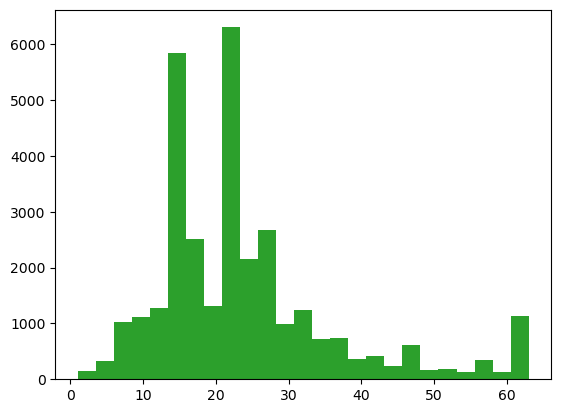

In [40]:
from numpy import exp
from numpy.random import randn
from sklearn.preprocessing import PowerTransformer
from matplotlib import pyplot


pyplot.hist(y, bins=25)
pyplot.show()

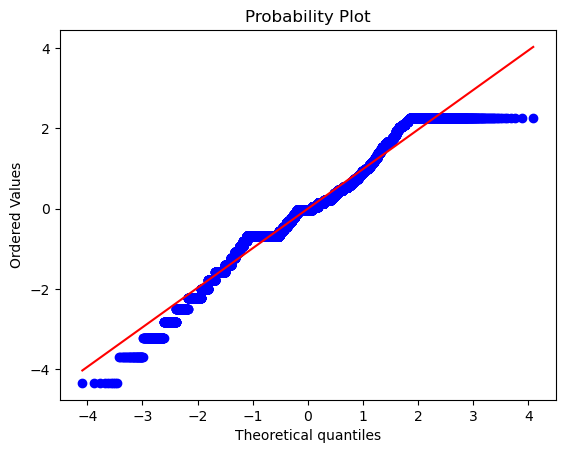

In [102]:
#Variables follow a Normal Distribution
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(y.ravel(), dist="norm", plot=plt)
plt.show()

#np.log(x)

In [34]:
y = np.sqrt(y)

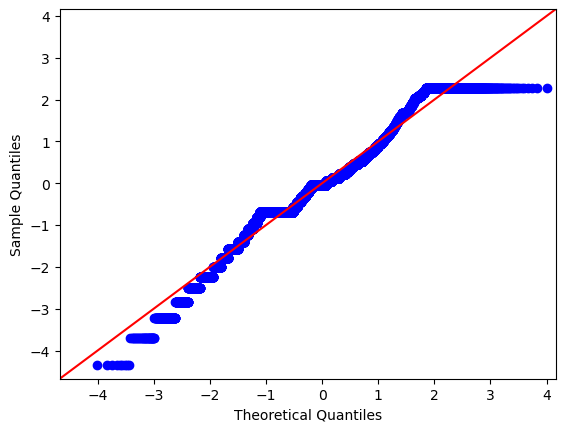

In [103]:
import numpy as np
import statsmodels.api as sm
import pylab

sm.qqplot(y.ravel(), line='45')
pylab.show()

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(25653, 285) (6414, 285) (25653, 1) (6414, 1)


In [105]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

In [137]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score


gbr = GradientBoostingRegressor() 
gbr.fit(X_train, y_train)
score_gbr_best = cross_val_score(gbr, X_train, y_train, cv=5)
y_predict = gbr.predict(X_test)


print(score_gbr_best.mean())
print(gbr.score(X_test, y_test))


/Users/julia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/julia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/julia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/julia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

0.9864164795419118
0.9859953072092306


In [188]:
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
forest = RandomForestRegressor()
er = VotingRegressor([('rf', forest), ('gbr', gbr)])

er.fit(X_train, y_train.values.ravel())
score_er_best = cross_val_score(er, X_train, y_train.values.ravel(), cv=5)


In [142]:
print(score_er_best.mean())
print(er.score(X_test, y_test))

0.9893131285821329
0.9894255853372997


In [190]:
yhat=er.predict(X_test)

r2score=r2_score(y_test, yhat)
print(r2score)

mse=mean_squared_error(yhat, y_test)

import numpy as np
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
print('The normalized Root Mean Squared Error of our forecasts is {}'.format( ((round(np.sqrt(mse), 2))/ ((y_test.max() - y_test.min())*100))))

0.9816199156949768
The Mean Squared Error of our forecasts is 3.04
The Root Mean Squared Error of our forecasts is 1.74
The normalized Root Mean Squared Error of our forecasts is Projectduration_x    0.000281
dtype: float64


In [189]:
y_test.max()

Projectduration_x    63
dtype: int64

In [245]:
df_actualNR= df_actualNR.loc[:,~df_actualNR.columns.duplicated()]

In [246]:
df_actualNR

,ActualNR_sum_x,Actual Net Revenue - MTD,Funding Amount - ITC (Snapshot),Backlog NR,Actual Direct Labor Cost - MTD,Actual Non-Labor Cost - MTD,Actual Gross Revenue - MTD,EBITA - MTD,ADL_shifted,ANR_shifted,...,Other,Power/Util,Public,Transp/Log,Key Global,Key Regional,Local,High,Low,Medium
0,21839,2900.00,733572,92293.61,1276.25,0.00,2900.00,-111.9500,2.453807e+07,6.702559e+07,...,0,0,0,0,0,0,0,1,0,0
1,9093,0.00,97237,0.00,757.88,2700.00,2700.00,-1788.5968,2.453807e+07,6.702559e+07,...,1,0,0,0,0,0,0,1,0,0
2,-5175,397.50,386461,0.00,277.66,0.00,397.50,-257.7776,2.453807e+07,6.702559e+07,...,0,0,0,0,0,0,0,0,1,0
3,1177,706.50,22500,942.00,220.50,0.00,706.50,186.1200,2.453807e+07,6.702559e+07,...,0,0,0,0,0,0,0,0,1,0
4,13458,817.24,50676,0.00,537.55,14.92,832.16,-451.3780,2.453807e+07,6.702559e+07,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32062,32140,14996.00,44575,0.00,4700.65,0.00,14996.00,3152.7100,5.147722e+06,1.471307e+07,...,0,0,0,0,0,1,0,0,0,0
32063,2793,0.00,0,0.00,0.00,0.00,0.00,0.0000,1.082843e+07,2.861349e+07,...,0,1,0,0,0,0,1,0,0,0
32064,39282,1176.01,43500,24729.07,454.76,0.00,1176.01,148.0700,1.322915e+07,3.297292e+07,...,0,0,0,0,1,0,0,0,0,0
32065,51657,0.00,107400,48943.24,0.00,0.00,0.00,0.0000,1.671872e+07,4.562350e+07,...,0,0,0,0,1,0,0,0,0,0


In [247]:
import re

df_actualNR.columns.rename(lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

Index([                 'ActualNR_sum_x',        'Actual Net Revenue - MTD',
       'Funding Amount - ITC (Snapshot)',                      'Backlog NR',
        'Actual Direct Labor Cost - MTD',     'Actual Non-Labor Cost - MTD',
            'Actual Gross Revenue - MTD',                     'EBITA - MTD',
                           'ADL_shifted',                     'ANR_shifted',
       ...
                                 'Other',                      'Power/Util',
                                'Public',                      'Transp/Log',
                            'Key Global',                    'Key Regional',
                                 'Local',                            'High',
                                   'Low',                          'Medium'],
      dtype='object', name=<function <lambda> at 0x7fdfdfce58c0>, length=287)

In [248]:
df_actualNR.head()

,ActualNR_sum_x,Actual Net Revenue - MTD,Funding Amount - ITC (Snapshot),Backlog NR,Actual Direct Labor Cost - MTD,Actual Non-Labor Cost - MTD,Actual Gross Revenue - MTD,EBITA - MTD,ADL_shifted,ANR_shifted,...,Other,Power/Util,Public,Transp/Log,Key Global,Key Regional,Local,High,Low,Medium
0,21839,2900.00,733572,92293.61,1276.25,0.00,2900.00,-111.9500,2.453807e+07,6.702559e+07,...,0,0,0,0,0,0,0,1,0,0
1,9093,0.00,97237,0.00,757.88,2700.00,2700.00,-1788.5968,2.453807e+07,6.702559e+07,...,1,0,0,0,0,0,0,1,0,0
2,-5175,397.50,386461,0.00,277.66,0.00,397.50,-257.7776,2.453807e+07,6.702559e+07,...,0,0,0,0,0,0,0,0,1,0
3,1177,706.50,22500,942.00,220.50,0.00,706.50,186.1200,2.453807e+07,6.702559e+07,...,0,0,0,0,0,0,0,0,1,0
4,13458,817.24,50676,0.00,537.55,14.92,832.16,-451.3780,2.453807e+07,6.702559e+07,...,0,0,0,0,0,0,0,1,0,0


In [261]:
from sklearn.model_selection import train_test_split

X = df_actualNR.iloc[:,1:]
y = df_actualNR.iloc[:,:1]

X.fillna(0, inplace=True)
y.fillna(0, inplace=True)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(25653, 286) (6414, 286) (25653, 1) (6414, 1)


In [273]:
y_train

,ActualNR_sum_x
20096,3400
8356,43193
6171,41943
1919,11525
15077,651029
...,...
1483,4946
19127,0
14776,0
29462,1329


In [275]:
#X_train= df['Total'] /= max(df['Total'])
#X_test = df['Total'] /= max(df['Total'])
y_train['ActualNR_sum_x'] /= max(y_train['ActualNR_sum_x'])
y_test['ActualNR_sum_x'] /= max(y_test['ActualNR_sum_x'])

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/julia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
from math import sqrt 
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

param = {'objective': 'regression',
         'boosting': 'gbdt',
         'num_iterations': 3000,   
         'learning_rate': 0.06,  
         'num_leaves': 40,  
         'max_depth': 24,   
         'min_data_in_leaf':11,  
         'max_bin': 4, 
         'metric': 'l2_root'
         }

                        
                        
param = np.array(param)

lgbm = lgb.train(params=param,
                 verbose_eval=1000,
                 train_set=train_data, valid_sets=test_data)

In [84]:
y_test = y_test.to_numpy()

importance = gbr.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00040
Feature: 1, Score: 0.00030
Feature: 2, Score: 0.00011
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00029
Feature: 6, Score: 0.00014
Feature: 7, Score: 0.00001
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00199
Feature: 10, Score: 0.00257
Feature: 11, Score: 0.34940
Feature: 12, Score: 0.06541
Feature: 13, Score: 0.09623
Feature: 14, Score: 0.02818
Feature: 15, Score: 0.00014
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00033
Feature: 18, Score: 0.00051
Feature: 19, Score: 0.00024
Feature: 20, Score: 0.00022
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00006
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00005
Feature: 28, Score: 0.00022
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00035
Fe

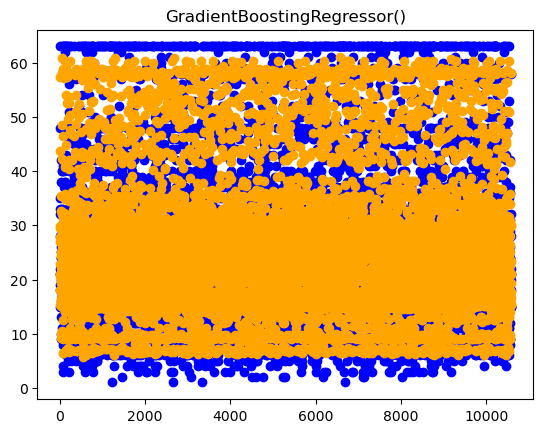

In [90]:
plotGraph(y_test, y_predict, gbr)

In [107]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
forest.fit(X_train, y_train.ravel())
score_forest_best = cross_val_score(forest, X_train, y_train.ravel(), cv=5)
print(score_forest_best.mean())
print(forest.score())


0.9865123334340451
0.9852813579020437


In [118]:
y_predict= forest.predict(X_test)

In [108]:
importance = forest.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00031
Feature: 1, Score: 0.00096
Feature: 2, Score: 0.00788
Feature: 3, Score: 0.00038
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00034
Feature: 6, Score: 0.00093
Feature: 7, Score: 0.00060
Feature: 8, Score: 0.00059
Feature: 9, Score: 0.00060
Feature: 10, Score: 0.00081
Feature: 11, Score: 0.11859
Feature: 12, Score: 0.06733
Feature: 13, Score: 0.07388
Feature: 14, Score: 0.04283
Feature: 15, Score: 0.00005
Feature: 16, Score: 0.00005
Feature: 17, Score: 0.00022
Feature: 18, Score: 0.00015
Feature: 19, Score: 0.00007
Feature: 20, Score: 0.00013
Feature: 21, Score: 0.00007
Feature: 22, Score: 0.00008
Feature: 23, Score: 0.00009
Feature: 24, Score: 0.00008
Feature: 25, Score: 0.00016
Feature: 26, Score: 0.00023
Feature: 27, Score: 0.00027
Feature: 28, Score: 0.00041
Feature: 29, Score: 0.00009
Feature: 30, Score: 0.00008
Feature: 31, Score: 0.00011
Feature: 32, Score: 0.00013
Feature: 33, Score: 0.00011
Feature: 34, Score: 0.00018
Feature: 35, Score: 0.00031
Fe

In [119]:
df_actuaDR.iloc[:, 263:]

,TC - Telecom Utilities,TRN - Transportation (Non-Rail Road),TS - Transit,Unspecified,WC - Water Companies/Utilities,Commercials,Federal,Intercompany,Life Sci,Manufacturing,...,Transp/Log,Key Global,Key Local,Key Regional,Local,RKC,Unspecified,Low,Medium,Unspecified
0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32062,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
32063,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
32064,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
32065,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


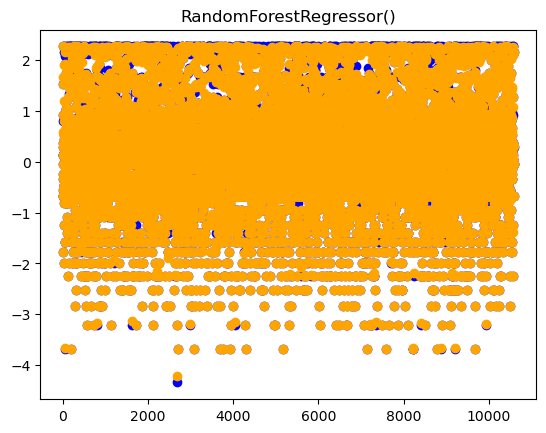

In [120]:
plotGraph(y_test, y_predict, forest)